In [12]:
import os
import json
import numpy as np
import pandas as pd
import pycountry
import datetime
import pickle
import pytz
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
# import lightgbm as lgb

# # Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 9999
pd.options.display.max_rows = 3000
pd.options.display.max_colwidth = 9999

In [2]:
def load_df(csv_path, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [6]:
%%time
train = load_df('input/train.csv')
test = load_df("input/test.csv")

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)
CPU times: user 5min 35s, sys: 2min 30s, total: 8min 5s
Wall time: 9min


In [9]:
# import pickle
# with open("input/train", "wb") as f:
#     pickle.dump(train, f)
    
# with open("input/test", "wb") as f:
#     pickle.dump(test, f)

In [16]:
# import pickle
# with open("input/train_with_date", "wb") as f:
#     pickle.dump(train, f)
    
# with open("input/test_with_date", "wb") as f:
#     pickle.dump(test, f)

In [2]:
%%time
import pickle
with open("input/train", "rb") as f:
    train = pickle.load(f)
with open("input/test", "rb") as f:
    test = pickle.load(f)
    
train["totals.transactionRevenue"] = train["totals.transactionRevenue"].astype("float")

CPU times: user 5.62 s, sys: 1.94 s, total: 7.55 s
Wall time: 8.03 s


In [3]:
train.shape, test.shape

((903653, 55), (804684, 53))

In [4]:
def get_country_to_timezone_mapping():
    
    from pytz import country_timezones


    countrycode_to_timezone = {}
    for countrycode in country_timezones:
        timezones = country_timezones[countrycode]
        for timezone in timezones:
            countrycode_to_timezone[countrycode] = timezone

    name_to_code = {x.name.lower().replace(" ", ""): x.alpha_2 for x in pycountry.countries} 
    
    countries = {
        "Bosnia & Herzegovina": "bosniaandherzegovina",
        'Macedonia (FYROM)': 'macedonia,republicof',
        'Kosovo': 'egypt',  # same GTC as Egypt
        'Côte d’Ivoire': "côted'ivoire",
        'Myanmar (Burma)': 'myanmar',
        'Trinidad & Tobago': 'trinidadandtobago',
        "South Korea": "korea",
        'Laos': "thailand",
        "Macau": "hongkong",
        'Congo - Brazzaville':'congo,thedemocraticrepublicofthe',
        'Congo - Kinshasa': 'congo',
        'St. Lucia': 'saintlucia',
        "U.S. Virgin Islands": "virginislands,u.s.",
        'Cape Verde':'caboverde',
        'Turks & Caicos Islands': 'turksandcaicosislands',
        'St. Vincent & Grenadines': 'saintvincentandthegrenadines',
        'St. Kitts & Nevis': 'saintkittsandnevis',
        'British Virgin Islands': "virginislands,british",
        'Antigua & Barbuda': 'antiguaandbarbuda',
        'Caribbean Netherlands': 'netherlands',
        'St. Barthélemy': 'saintbarthélemy',
        'St. Martin': 'saintmartin(frenchpart)',
        'São Tomé & Príncipe': 'saotomeandprincipe',
        'St. Pierre & Miquelon': 'saintpierreandmiquelon',
        'St. Helena': 'Saint Helena, Ascension and Tristan da Cunha',
    }
    
    couns = pd.concat([train["geoNetwork.country"], test["geoNetwork.country"]], axis=0).value_counts().index

    country_to_timezone_dict = {}

    count = 0
    for c in couns:
        for key in name_to_code.keys():
            if c.lower().replace(" ", "") in key.lower() or (countries.get(c) is not None and countries.get(c) in key.lower()):
                country_to_timezone_dict[c] = countrycode_to_timezone[name_to_code[key]]
                break

    return country_to_timezone_dict

In [7]:
def get_date_features(df):
    import dateutil
    from_zone = dateutil.tz.gettz('UTC')
    
    country_to_tz_mapping = get_country_to_timezone_mapping()
    df["timezone"] = df["geoNetwork.country"].map(country_to_tz_mapping)
    df["visitStartTimeUTCDate"] = df["visitStartTimeUTCDate"].apply(lambda x: x.replace(tzinfo=from_zone))
    
    print(df["geoNetwork.country"].isnull().sum())
    print(df["timezone"].isnull().sum())
    null_index = df.index[df["timezone"].isnull()]

    local_times = []
    for index in df.index:
        if index in null_index:
            local_times.append(df.loc[index, "visitStartTimeUTCDate"])
        else:
            cur_tz = pytz.timezone(df.loc[index, "timezone"])
            local_times.append(df.loc[index, "visitStartTimeUTCDate"].astimezone(cur_tz))
        
    df["visitStartTimeLocalDate"] = local_times
    df["visitStartTimeLocal_WeekdayName"] = df["visitStartTimeLocalDate"].apply(lambda x: x.weekday_name)
    df["visitStartTimeLocal_Hour"] = df["visitStartTimeLocalDate"].apply(lambda x: x.hour)
    df["visitStartTimeLocal_Month"] = df["visitStartTimeLocalDate"].apply(lambda x: x.month)
    df["visitStartTimeLocal_DayOfYear"] = df["visitStartTimeLocalDate"].apply(lambda x: x.dayofyear)
    df["visitStartTimeLocal_DaysInMonth"] = df["visitStartTimeLocalDate"].apply(lambda x: x.daysinmonth)
    df["visitStartTimeLocal_Quarter"] = df["visitStartTimeLocalDate"].apply(lambda x: x.quarter)
    df["visitStartTimeLocal_WeekOfYear"] = df["visitStartTimeLocalDate"].apply(lambda x: x.weekofyear)
    
    return df

In [8]:
def preprocess_data(df, isTrain=True):
    non_const_cols = [c for c in df.columns if df[c].nunique(dropna=False) != 1 ]
    df = df[non_const_cols]
    df["date"] = pd.to_datetime(df["date"].astype(str))
    df["totals.bounces"] = df["totals.bounces"].astype("str")
    df["totals.newVisits"] = df["totals.newVisits"].astype("str")
#     df["totals.newVisits"] = df["totals.newVisits"].replace("nan", 0)
    df["totals.hits"] = df["totals.hits"].astype("float")
    df["totals.pageviews"] = df["totals.pageviews"].astype("float")
    df["visitStartTimeUTCDate"] = df["visitStartTime"].apply(lambda x: datetime.datetime.utcfromtimestamp(x))

    df = df.replace(["not available in demo dataset", "(not set)", "unknown.unknown", "(not provided)"], np.nan)
    
    df = get_date_features(df)
#     if isTrain:
#         df["revenue-type"] = "non-zero-revenue"
#         df["revenue-type"][df["totals.transactionRevenue"].isnull()] = "zero-revenue"
    return df

In [13]:
%%time
train = preprocess_data(train)
test = preprocess_data(test, isTrain=False)
train.head()

1468
1468
1049
1050
CPU times: user 2min 31s, sys: 4.1 s, total: 2min 35s
Wall time: 2min 15s


In [14]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,visitStartTimeUTCDate,timezone,visitStartTimeLocalDate,visitStartTimeLocal_WeekdayName,visitStartTimeLocal_Hour,visitStartTimeLocal_Month,visitStartTimeLocal_DayOfYear,visitStartTimeLocal_DaysInMonth,visitStartTimeLocal_Quarter,visitStartTimeLocal_WeekOfYear
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,desktop,False,Windows,Izmir,Asia,Turkey,NaN,ttnet.com.tr,Izmir,Western Asia,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,organic,NaN,google,2016-09-02 15:33:05+00:00,Europe/Istanbul,2016-09-02 18:33:05+03:00,Friday,18,9,246,30,3,35
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,desktop,False,Macintosh,NaN,Oceania,Australia,NaN,dodo.net.au,NaN,Australasia,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,organic,NaN,google,2016-09-03 05:22:27+00:00,Australia/Eucla,2016-09-03 14:07:27+08:45,Saturday,14,9,247,30,3,35
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,desktop,False,Windows,Madrid,Europe,Spain,NaN,NaN,Community of Madrid,Southern Europe,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,organic,NaN,google,2016-09-03 01:16:26+00:00,Atlantic/Canary,2016-09-03 02:16:26+01:00,Saturday,2,9,247,30,3,35
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,desktop,False,Linux,NaN,Asia,Indonesia,NaN,NaN,NaN,Southeast Asia,1,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,google + online,organic,NaN,google,2016-09-03 05:40:13+00:00,Asia/Jayapura,2016-09-03 14:40:13+09:00,Saturday,14,9,247,30,3,35
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,mobile,True,Android,NaN,Europe,United Kingdom,NaN,NaN,NaN,Northern Europe,1,1.0,nan,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,organic,NaN,google,2016-09-02 13:23:20+00:00,Europe/London,2016-09-02 14:23:20+01:00,Friday,14,9,246,30,3,35


In [15]:
date_cols = [c for c in train.columns if c.startswith("visitStart") or c.startswith("date")]
train[date_cols].head()

,date,visitStartTime,visitStartTimeUTCDate,visitStartTimeLocalDate,visitStartTimeLocal_WeekdayName,visitStartTimeLocal_Hour,visitStartTimeLocal_Month,visitStartTimeLocal_DayOfYear,visitStartTimeLocal_DaysInMonth,visitStartTimeLocal_Quarter,visitStartTimeLocal_WeekOfYear
0,2016-09-02,1472830385,2016-09-02 15:33:05+00:00,2016-09-02 18:33:05+03:00,Friday,18,9,246,30,3,35
1,2016-09-02,1472880147,2016-09-03 05:22:27+00:00,2016-09-03 14:07:27+08:45,Saturday,14,9,247,30,3,35
2,2016-09-02,1472865386,2016-09-03 01:16:26+00:00,2016-09-03 02:16:26+01:00,Saturday,2,9,247,30,3,35
3,2016-09-02,1472881213,2016-09-03 05:40:13+00:00,2016-09-03 14:40:13+09:00,Saturday,14,9,247,30,3,35
4,2016-09-02,1472822600,2016-09-02 13:23:20+00:00,2016-09-02 14:23:20+01:00,Friday,14,9,246,30,3,35


In [852]:
train["revenue-type"] = "non-zero-revenue"
train["revenue-type"][train["totals.transactionRevenue"].isnull()] = "zero-revenue"
train["totals.transactionRevenue"].fillna(0, inplace=True)

In [853]:
non_zero_train = train[train["revenue-type"] == "non-zero-revenue"]
non_zero_train["totals.transactionRevenue"] = np.log1p(non_zero_train["totals.transactionRevenue"])

zero_train = train[train["revenue-type"] == "zero-revenue"]
zero_train.shape, non_zero_train.shape, non_zero_train.shape[0] / train.shape[0]

((892138, 38), (11515, 38), 0.0127427231470487)

In [496]:
train["revenue-type"].value_counts(), train["totals.transactionRevenue"].isnull().sum()

(zero-revenue        892138
 non-zero-revenue     11515
 Name: revenue-type, dtype: int64, 0)

# Missing data ratio

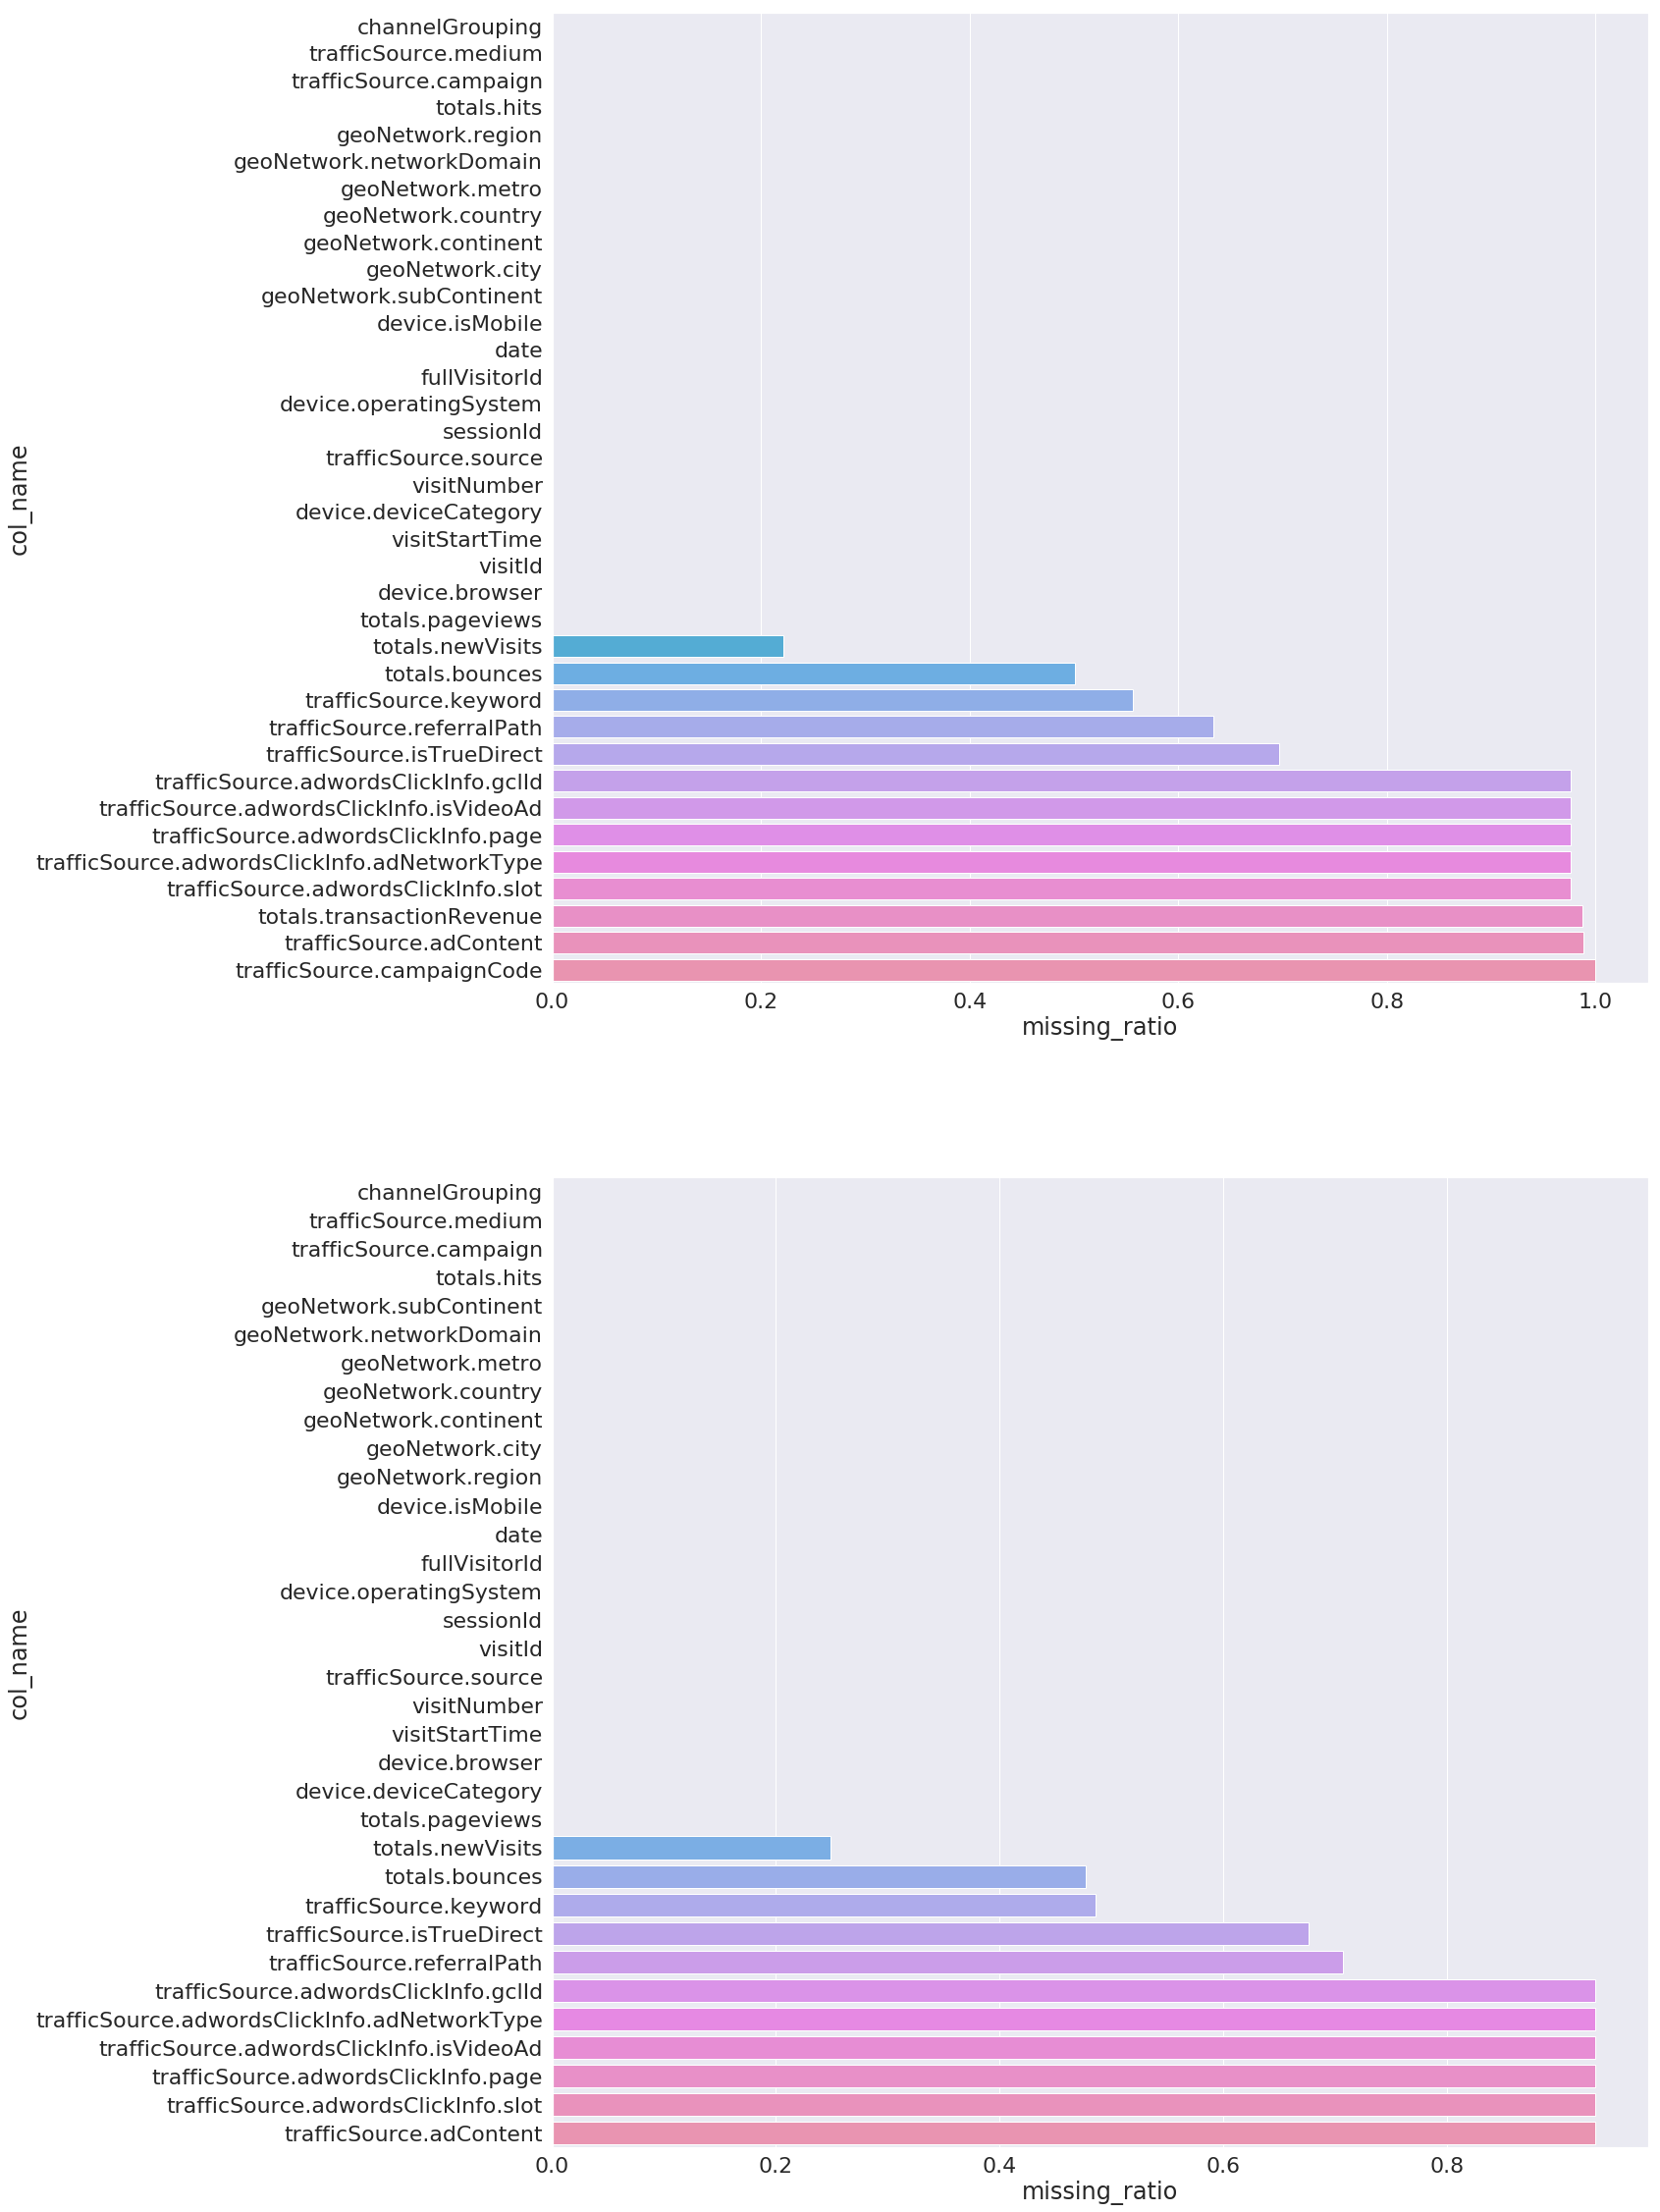

In [151]:
sns.set(font_scale=2)  # crazy big
fig, axs = plt.subplots(figsize=(20,40), nrows=2, ncols=1)
mr = (pd.isnull(train).sum() / train.shape[0]).reset_index().rename(columns={"index": "col_name", 0: "missing_ratio"}).sort_values("missing_ratio")
mr_test = (pd.isnull(test).sum() / test.shape[0]).reset_index().rename(columns={"index": "col_name", 0: "missing_ratio"}).sort_values("missing_ratio")
sns.barplot(x="missing_ratio", y="col_name", data=mr, ax=axs[0])
sns.barplot(x="missing_ratio", y="col_name", data=mr_test, ax=axs[1])

In [161]:
train["totals.bounces"].value_counts(), test["totals.bounces"].value_counts(), \
train["totals.newVisits"].value_counts(), test["totals.newVisits"].value_counts()

(1.0    450630
 Name: totals.bounces, dtype: int64, 1.0    420948
 Name: totals.bounces, dtype: int64, 1.0    703060
 Name: totals.newVisits, dtype: int64, 1.0    604370
 Name: totals.newVisits, dtype: int64)

In [170]:
train["fullVisitorId"].nunique()

714167

In [177]:
d = train["fullVisitorId"].value_counts()
d[d<=1].sum()   # conclusion: in this dataset of this period, a visitor only visit once but is not new visitor

620675

In [241]:
totals_cols = [c for c in train.columns if c.startswith("totals")]
train[totals_cols].corr()

# conclusion:
# pageviews and hits have high correlation. we use any one of them for analysis

,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue
totals.bounces,1.000000,-0.371136,0.078841,-0.404617,-0.032206
totals.hits,-0.371136,1.000000,-0.115202,0.983205,0.154333
totals.newVisits,0.078841,-0.115202,1.000000,-0.117263,-0.041164
totals.pageviews,-0.404617,0.983205,-0.117263,1.000000,0.155590
totals.transactionRevenue,-0.032206,0.154333,-0.041164,0.155590,1.000000


# Transaction Revenue

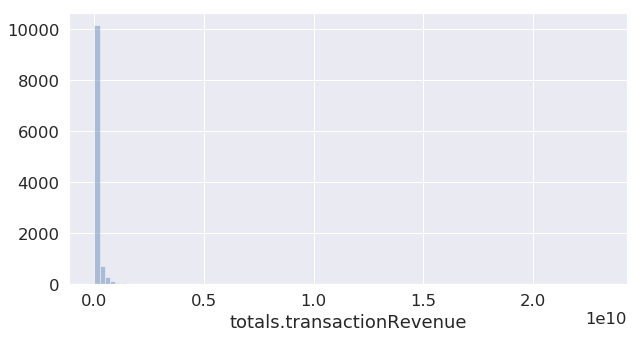

In [448]:
plt.figure(figsize=(10,5))
sns.distplot(np.expm1(train["totals.transactionRevenue"][train["totals.transactionRevenue"]!=0]), bins=100, kde=False)

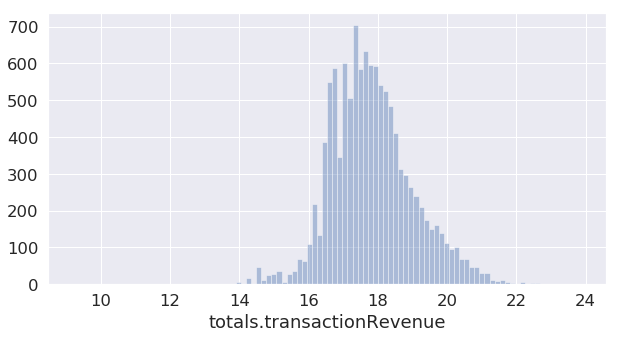

In [339]:
plt.figure(figsize=(10,5))
sns.distplot(train["totals.transactionRevenue"][train["totals.transactionRevenue"]!=0], bins=100, kde=False)

## Outliers

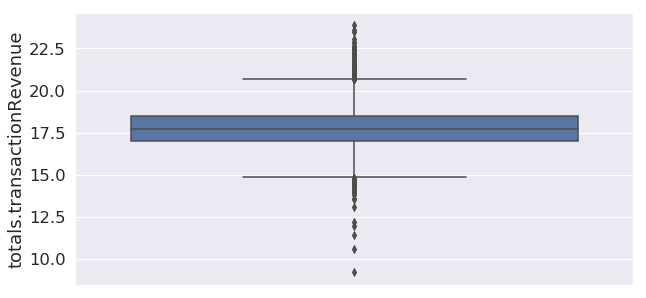

In [347]:
plt.figure(figsize=(10,5))
sns.boxplot(y="totals.transactionRevenue", data=train[train["totals.transactionRevenue"]!=0])
# Q1 Median Q3
# Interquartile range(IQR) == q3 - q1
# "minimum" = q1- 1.5 * IQR
# Lower than "minimum" = outliers

((301,),
 (11214,),
 0.026139817629179333,
 [array([17.0315825 , 17.0315825 , 18.49444193, 18.49444193, 17.0315825 ])],
 [array([17.0315825 , 14.84513033]), array([18.49444193, 20.68843627])])

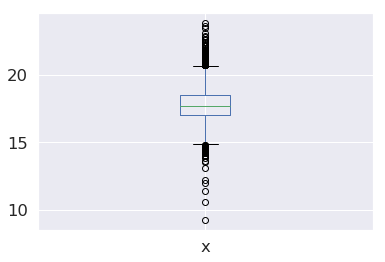

In [380]:
_, bp = pd.DataFrame.boxplot(non_zero_train["totals.transactionRevenue"], return_type='both')
outliers = [flier.get_ydata() for flier in bp["fliers"]]
boxes = [box.get_ydata() for box in bp["boxes"]]
medians = [median.get_ydata() for median in bp["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]]

outlier_index = non_zero_train[non_zero_train["totals.transactionRevenue"].isin(outliers[0])].index
non_outlier_index = non_zero_train[~non_zero_train["totals.transactionRevenue"].isin(outliers[0])].index

outlier_index.shape, non_outlier_index.shape, len(outliers[0]) / non_zero_train.shape[0],  \
boxes, whiskers
# 2% data are outliers for non-zero revenue

# outliers in revenue will affect your analysis of which variable has how much effect on the revenue

3584912845.131592 5910522062.023291

count    1.151500e+04
mean     1.337448e+08
std      4.482852e+08
min      1.000000e+04
25%      2.493000e+07
50%      4.945000e+07
75%      1.076550e+08
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

count    1.121400e+04
mean     9.893632e+07
std      1.397473e+08
min      2.800000e+06
25%      2.499000e+07
50%      4.823500e+07
75%      1.029800e+08
max      9.657700e+08
Name: totals.transactionRevenue, dtype: float64


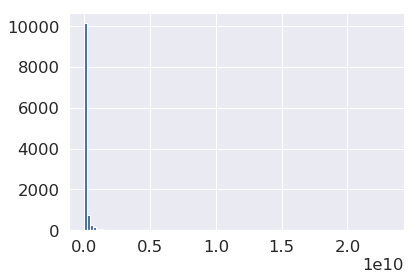

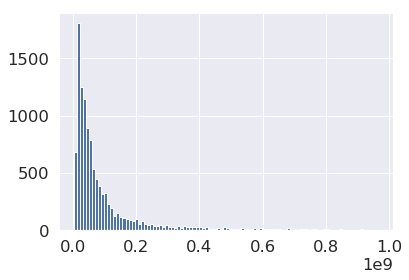

In [469]:
print(np.expm1(22), np.expm1(22.5))
print()
print(np.expm1(non_zero_train["totals.transactionRevenue"]).describe())

print()
print(np.expm1(non_zero_train["totals.transactionRevenue"][~non_zero_train.index.isin(outlier_index)]).describe())

np.expm1(non_zero_train["totals.transactionRevenue"]).hist(bins=100)
plt.show()
np.expm1(non_zero_train["totals.transactionRevenue"][~non_zero_train.index.isin(outlier_index)]).hist(bins=100)

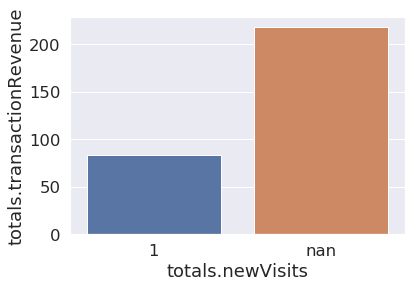

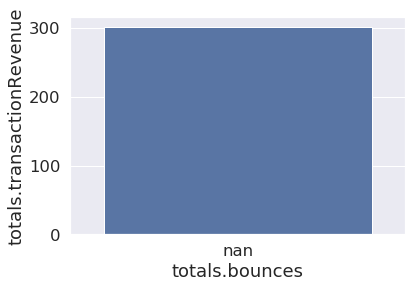

In [532]:
# non-zero revenue outliers distribution
sns.barplot(x="totals.newVisits", y="totals.transactionRevenue", data=train.loc[outlier_index], estimator=len)
plt.show()

sns.barplot(x="totals.bounces", y="totals.transactionRevenue", data=train.loc[outlier_index], estimator=len)
plt.show()


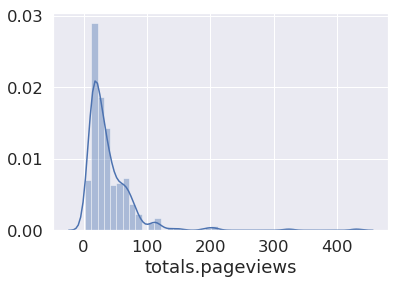

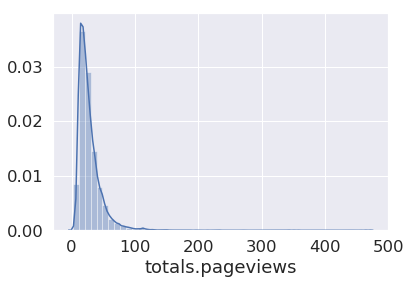

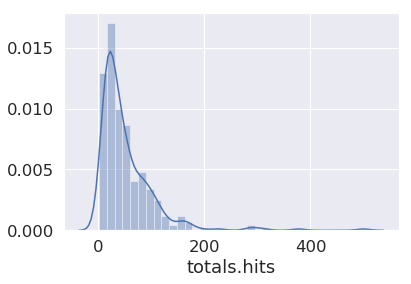

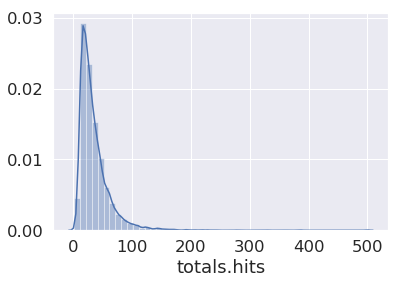

In [536]:
sns.distplot(train.loc[outlier_index]["totals.pageviews"])
plt.show()

sns.distplot(train.loc[non_outlier_index]["totals.pageviews"])
plt.show()

sns.distplot(train.loc[outlier_index]["totals.hits"])
plt.show()

sns.distplot(train.loc[non_outlier_index]["totals.hits"])
plt.show()

# conclusion:
# outliers have more hits and views that non-outliers

count    8.300000e+01
mean     6.669028e+08
std      9.597479e+08
min      2.000000e+05
25%      1.990000e+06
50%      1.990000e+06
75%      1.181150e+09
max      4.280700e+09
Name: totals.transactionRevenue, dtype: float64


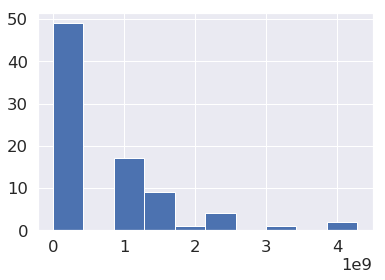

count    2.180000e+02
mean     1.721314e+09
std      2.569507e+09
min      1.000000e+04
25%      1.002315e+09
50%      1.218050e+09
75%      1.648630e+09
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64


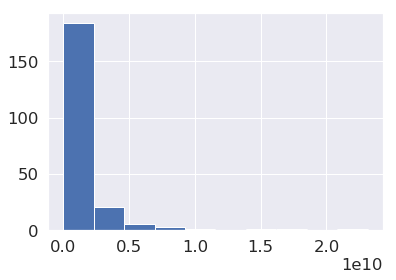

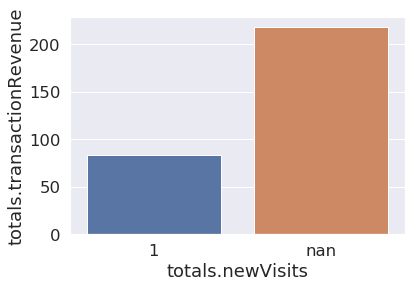

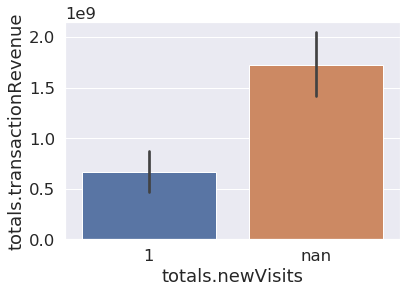

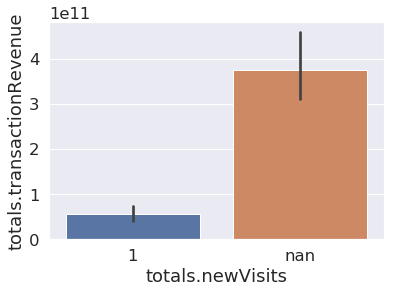

In [480]:
print(train.loc[outlier_index][train["totals.newVisits"] == '1']["totals.transactionRevenue"].describe())
train.loc[outlier_index][train["totals.newVisits"] == '1']["totals.transactionRevenue"].hist()
plt.show()

print(train.loc[outlier_index][train["totals.newVisits"] != '1']["totals.transactionRevenue"].describe())
train.loc[outlier_index][train["totals.newVisits"] != '1']["totals.transactionRevenue"].hist()
plt.show()

sns.barplot(x="totals.newVisits", y="totals.transactionRevenue", data=train.loc[outlier_index], estimator=len)
plt.show()

sns.barplot(x="totals.newVisits", y="totals.transactionRevenue", data=train.loc[outlier_index], estimator=np.mean)
plt.show()

sns.barplot(x="totals.newVisits", y="totals.transactionRevenue", data=train.loc[outlier_index], estimator=np.sum)
plt.show()

# 50% outliers for new visits are below 2*10e6
# 75% outliers for new visits are above 1*10e9

# Conclusion:
# HIgh revenue outlies are more likely to be in the non-new-visits
# low revenue outliers are more likely to be in the new-visits

# Need special feature to differentiate the outliers

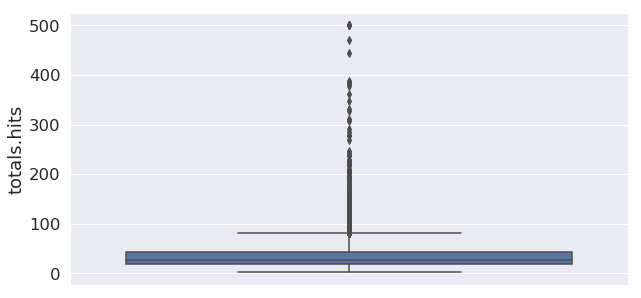

In [394]:
plt.figure(figsize=(10,5))
sns.boxplot(y="totals.hits", data=non_zero_train)

# HIts and pageviews distribution

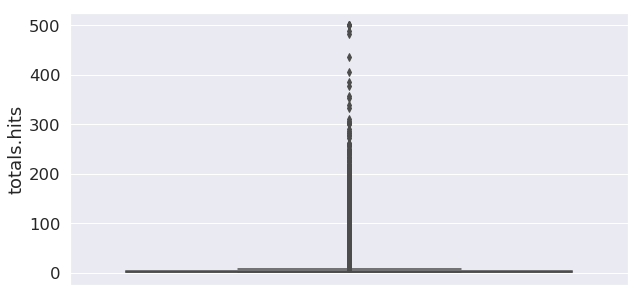

In [395]:

plt.figure(figsize=(10,5))
sns.boxplot(y="totals.hits", data=zero_train)

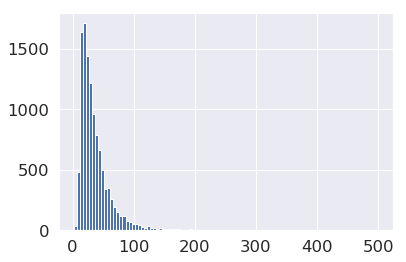

In [393]:
train[train["revenue-type"] == "non-zero-revenue"]["totals.hits"].hist(bins=100)

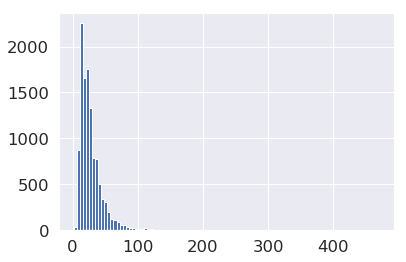

In [417]:
train[train["revenue-type"] == "non-zero-revenue"]["totals.pageviews"].hist(bins=100)

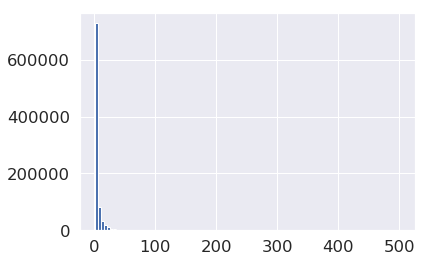

In [392]:
train[train["revenue-type"] == "zero-revenue"]["totals.hits"].hist(bins=100)

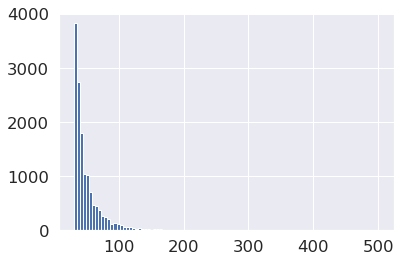

In [414]:
train[(train["revenue-type"] == "zero-revenue") & (train["totals.hits"] > 30)]["totals.hits"].hist(bins=100)

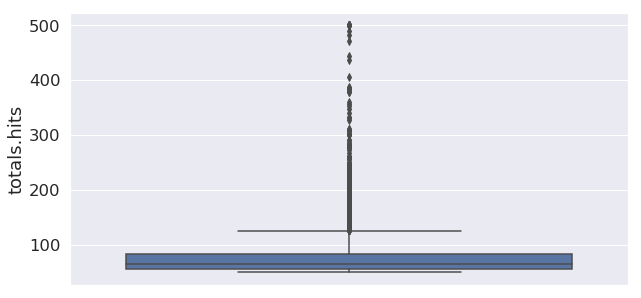

In [409]:
plt.figure(figsize=(10,5))
sns.boxplot(y="totals.hits", data=train[train["totals.hits"] >= 50])

In [415]:
non_zero_train[non_zero_train["totals.hits"] >= 130].shape, zero_train[zero_train["totals.hits"] >= 130].shape

# i want to know if high hits will lead to difference in revenue
# What we usually thought is that high number of hits may lead to more revenue
# in fact, seems that high hits don't make a lot of difference in the revenue
# maybe this user just walk around this session and then buy it next session
# maybe time series feature can help us
# for example, how many hits (average, or total) in the last several sessions for this user

((165, 38), (299, 38))

# multi-session or single session

In [633]:
sess_counts = train["fullVisitorId"].value_counts()
multi_sess_users = sess_counts[sess_counts >= 2].index
multi_sess_users.shape, sess_counts.shape

((93492,), (714167,))

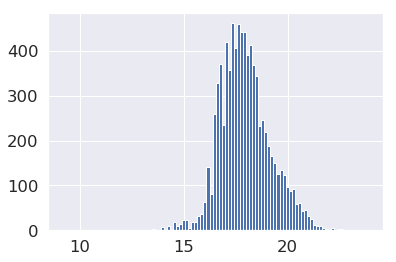

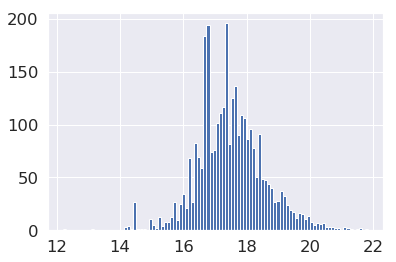

In [651]:
non_zero_train[non_zero_train["fullVisitorId"].isin(multi_sess_users)]["totals.transactionRevenue"].hist(bins=100)
plt.show()

non_zero_train[~non_zero_train["fullVisitorId"].isin(multi_sess_users)]["totals.transactionRevenue"].hist(bins=100)

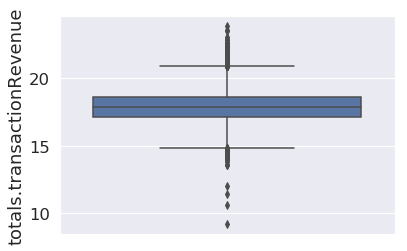

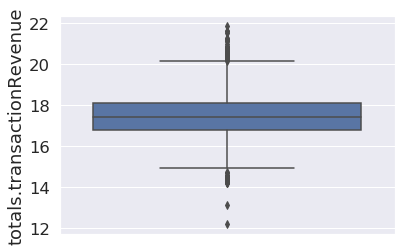

In [648]:
# Feature:
# visit time diff between last visit and this visit

sns.boxplot(y="totals.transactionRevenue",data=non_zero_train[non_zero_train["fullVisitorId"].isin(multi_sess_users)])
plt.show()

sns.boxplot(y="totals.transactionRevenue",data=non_zero_train[~non_zero_train["fullVisitorId"].isin(multi_sess_users)])

# conclusion
# 1. multi-session user has higher revenue and single session user
# 2. more loyal / old customer

# buy products continuously or discretely


In [502]:
def draw_barplot(x, y="totals.transactionRevenue", hue=None, exclude_outliers=False):
    sns.set(font_scale=1.5)  # crazy big
    fig, axs = plt.subplots(figsize=(20,72), nrows=9, ncols=1)

    non_zero_train_copy = non_zero_train.copy()
    if exclude_outliers:
        non_zero_train_copy = non_zero_train_copy.loc[non_outlier_index]
        
    sns.barplot(x=x, y=y, hue=hue, estimator=len, data=train, ax=axs[0])
    sns.barplot(x=x, y=y, hue=hue, estimator=len, data=zero_train, ax=axs[1])
    sns.barplot(x=x, y=y, hue=hue, estimator=len, data=non_zero_train_copy, ax=axs[2])

    sns.barplot(x=x, y=y, hue=hue, estimator=sum, data=non_zero_train_copy, ax=axs[3])
    sns.barplot(x=x, y=y, hue=hue, estimator=np.mean, data=non_zero_train_copy, ax=axs[4])
    sns.barplot(x=x, y=y, hue=hue, estimator=np.median, data=non_zero_train_copy, ax=axs[5])
    sns.barplot(x=x, y=y, hue=hue, estimator=np.std, data=non_zero_train_copy, ax=axs[6])
    sns.barplot(x=x, y=y, hue=hue, estimator=np.min, data=non_zero_train_copy, ax=axs[7])
    sns.barplot(x=x, y=y, hue=hue, estimator=np.max, data=non_zero_train_copy, ax=axs[8])

    axs[0].set_title("Revenue Count")
    axs[1].set_title("Zero Revenue Count")
    axs[2].set_title("Non Zero Revenue Count")

    axs[3].set_title("Non Zero Revenue Sum")
    axs[4].set_title("Non Zero Revenue Mean")
    axs[5].set_title("Non Zero Revenue Median")
    axs[6].set_title("Non Zero Revenue Std")
    axs[7].set_title("Non Zero Revenue Min")
    axs[8].set_title("Non Zero Revenue Max")

# New visits

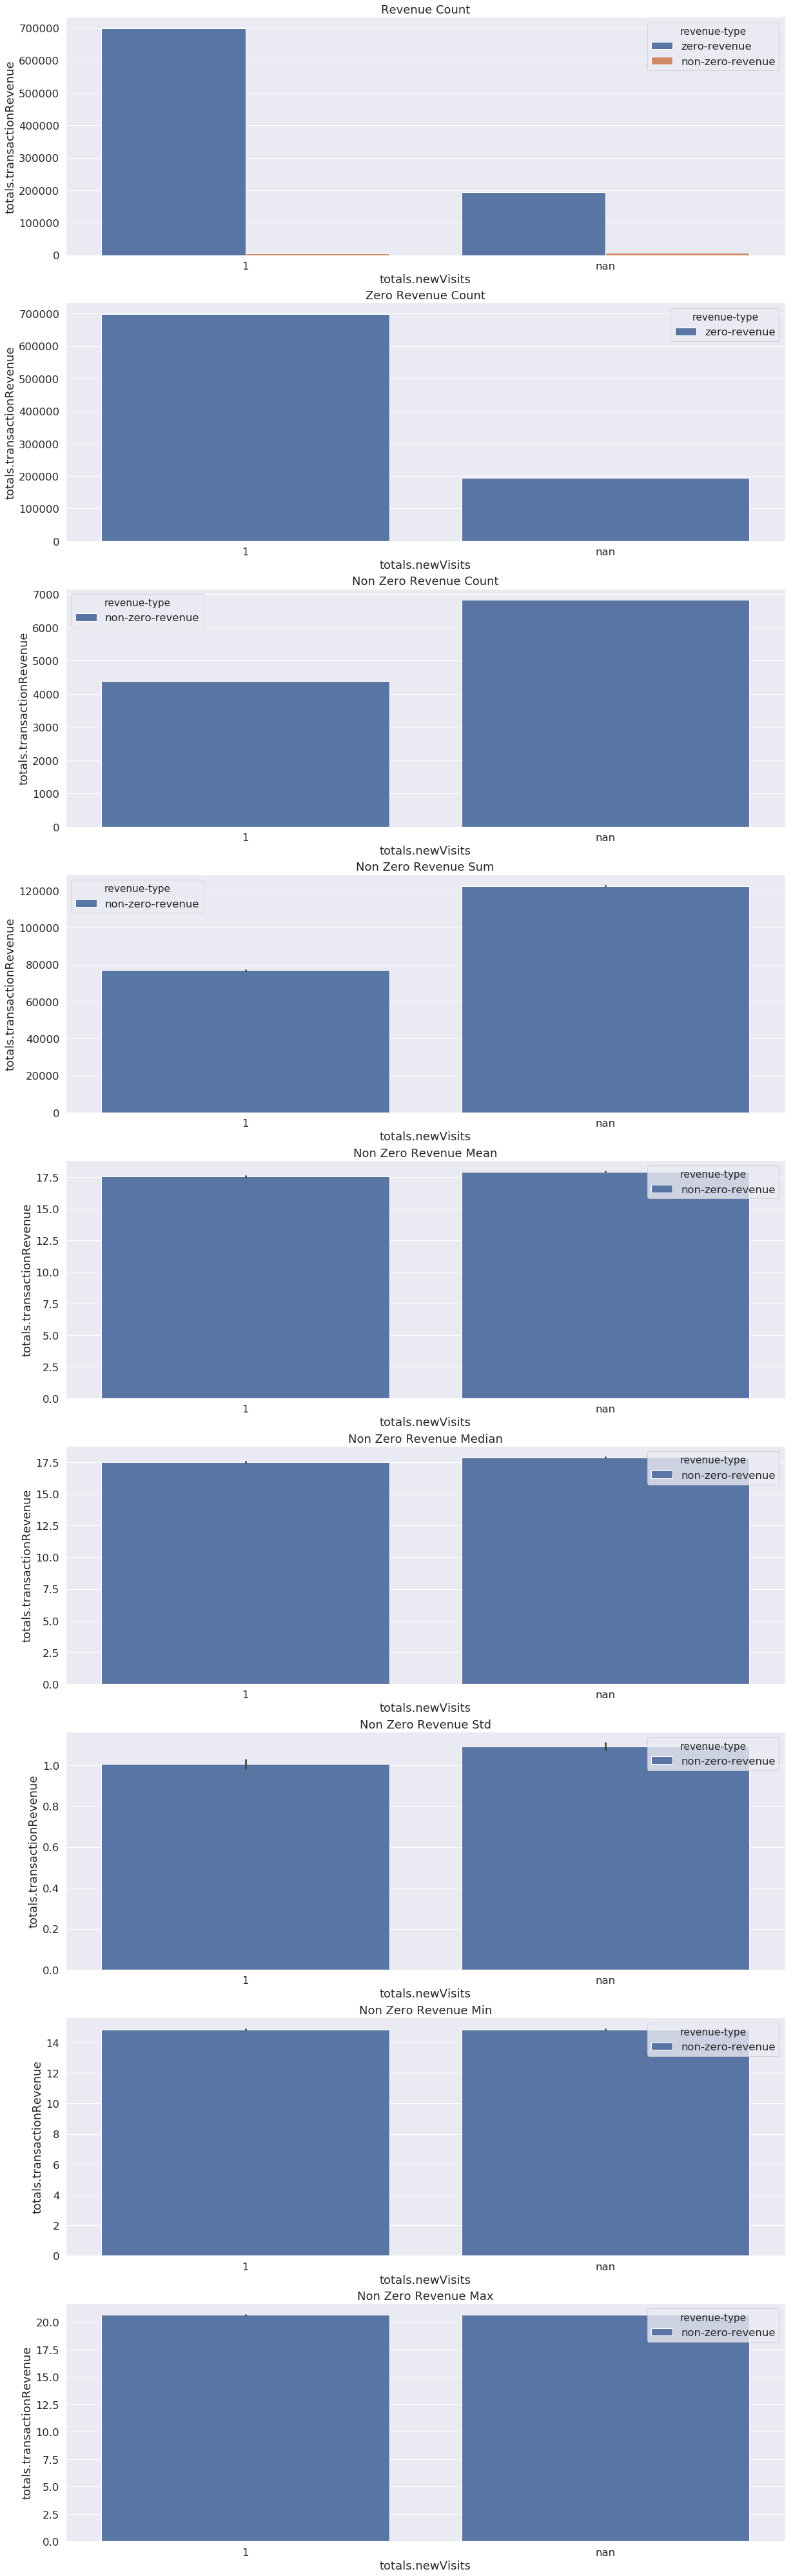

In [503]:
draw_barplot(x="totals.newVisits", y="totals.transactionRevenue", hue="revenue-type", exclude_outliers=True)

# non-new visits more likely to have revenue

In [507]:
non_zero_train[train["totals.newVisits"] == '1']["totals.transactionRevenue"].describe(), \
non_zero_train[train["totals.newVisits"] != '1']["totals.transactionRevenue"].describe(), \
np.expm1(17.56), np.expm1(17.989630)

# Conclusion:
# Non-new-visits has 50% more revenue than new-visits on average

(count    4465.000000
 mean       17.560834
 std         1.096646
 min        12.206078
 25%        16.783358
 50%        17.478559
 75%        18.197037
 max        22.177382
 Name: totals.transactionRevenue, dtype: float64, count    7050.000000
 mean       17.989630
 std         1.236530
 min         9.210440
 25%        17.147090
 50%        17.868686
 75%        18.692633
 max        23.864375
 Name: totals.transactionRevenue, dtype: float64, 42287410.531635806, 64982592.52017982)

# Bounces

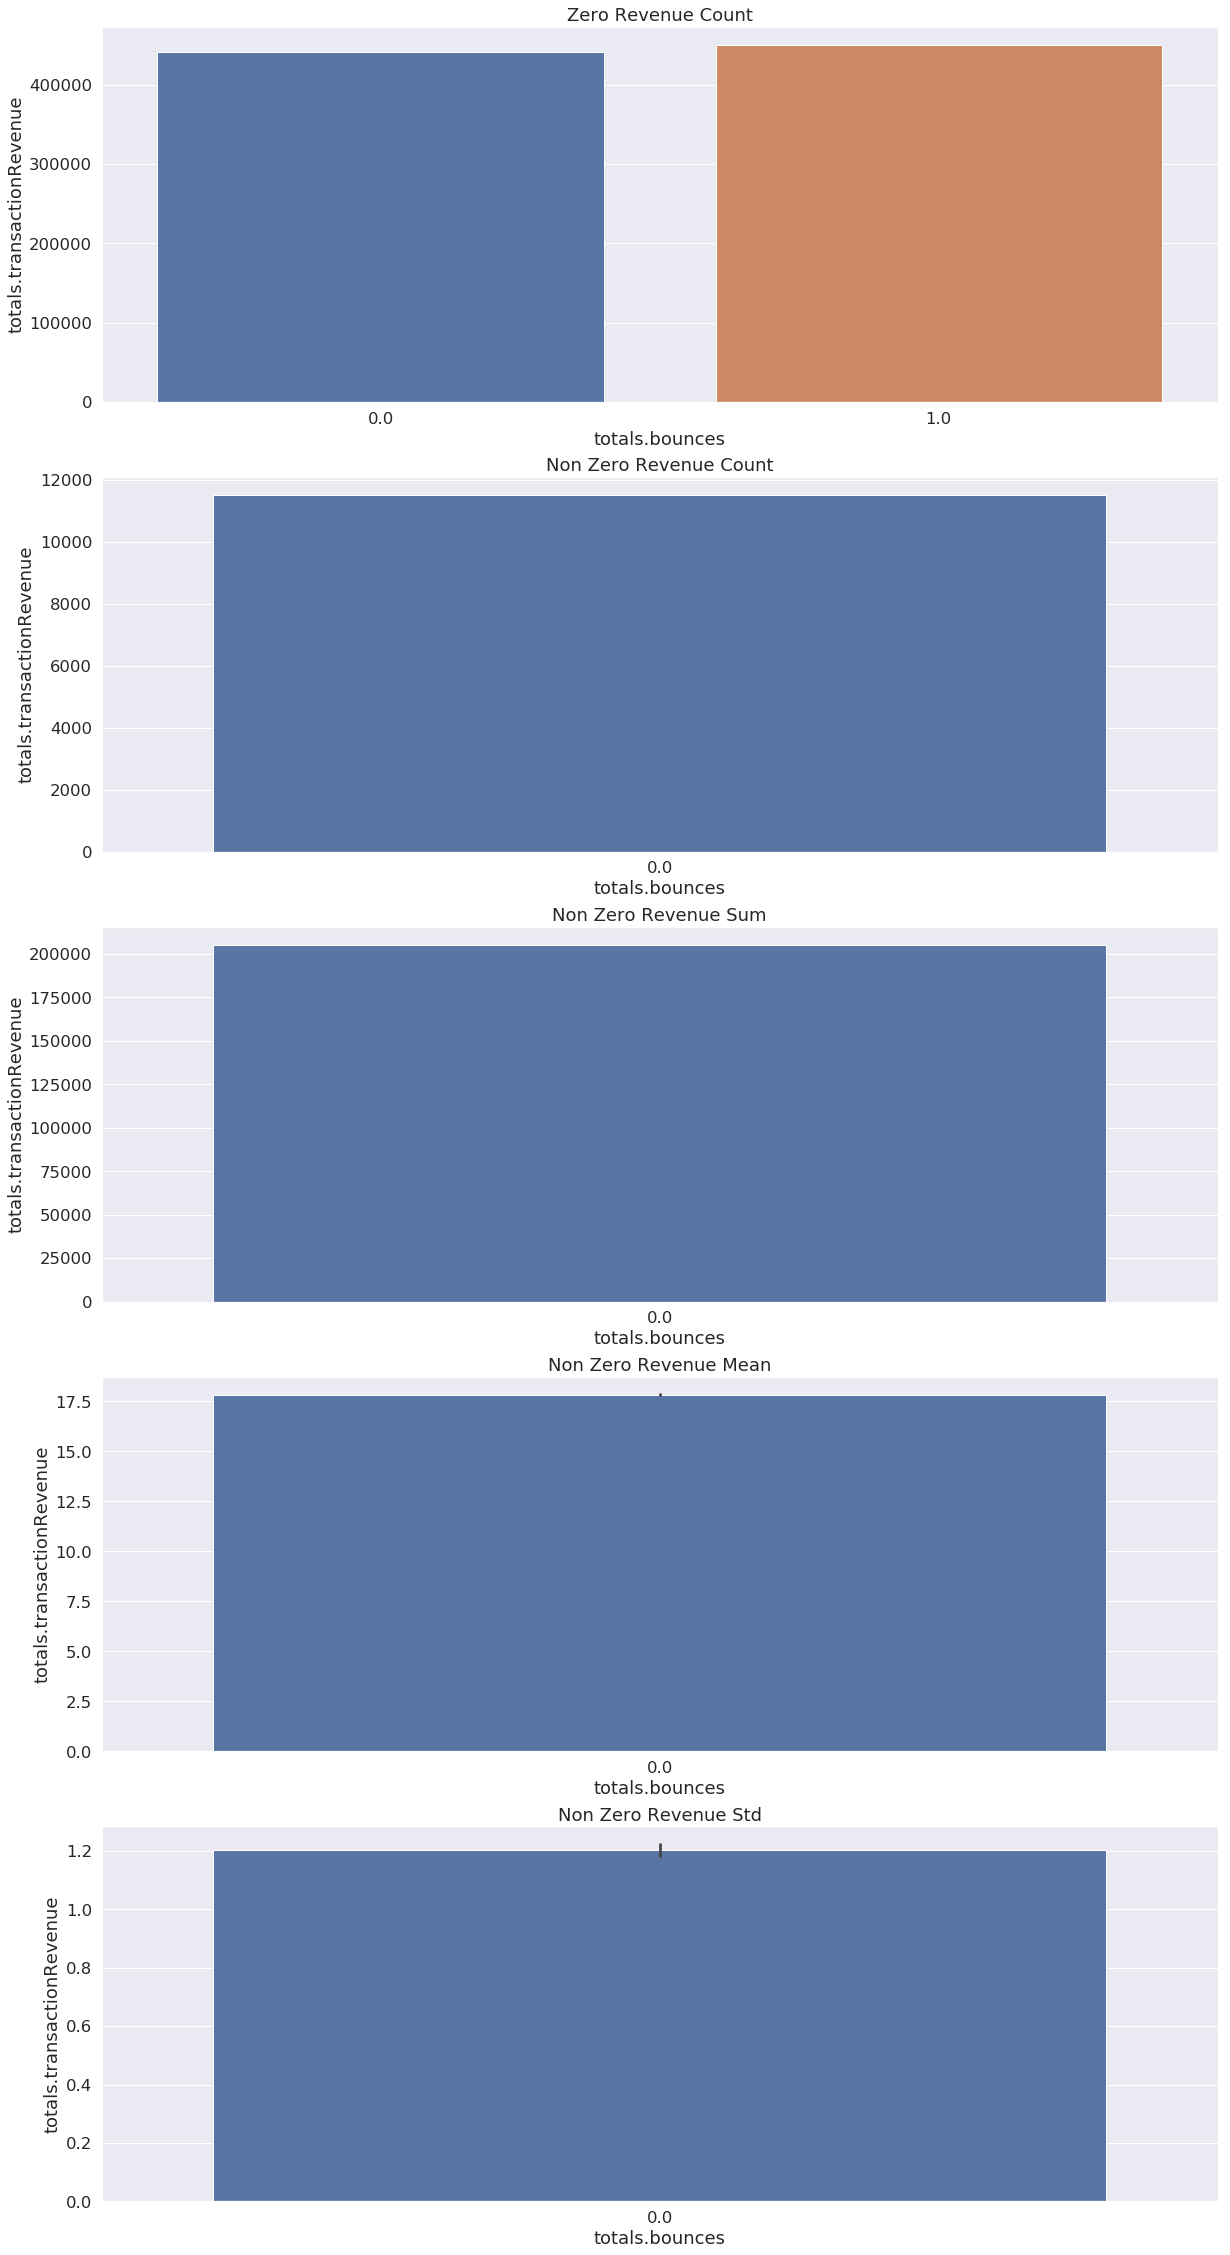

In [297]:
draw_barplot(x="totals.bounces")

# bounce and non-bounce have equal chance to have 0 revenue
# but only non-bounce people has non-zero revenue

# why some non-bounce people generate revenue while others not?

Text(0.5, 1.0, 'max')

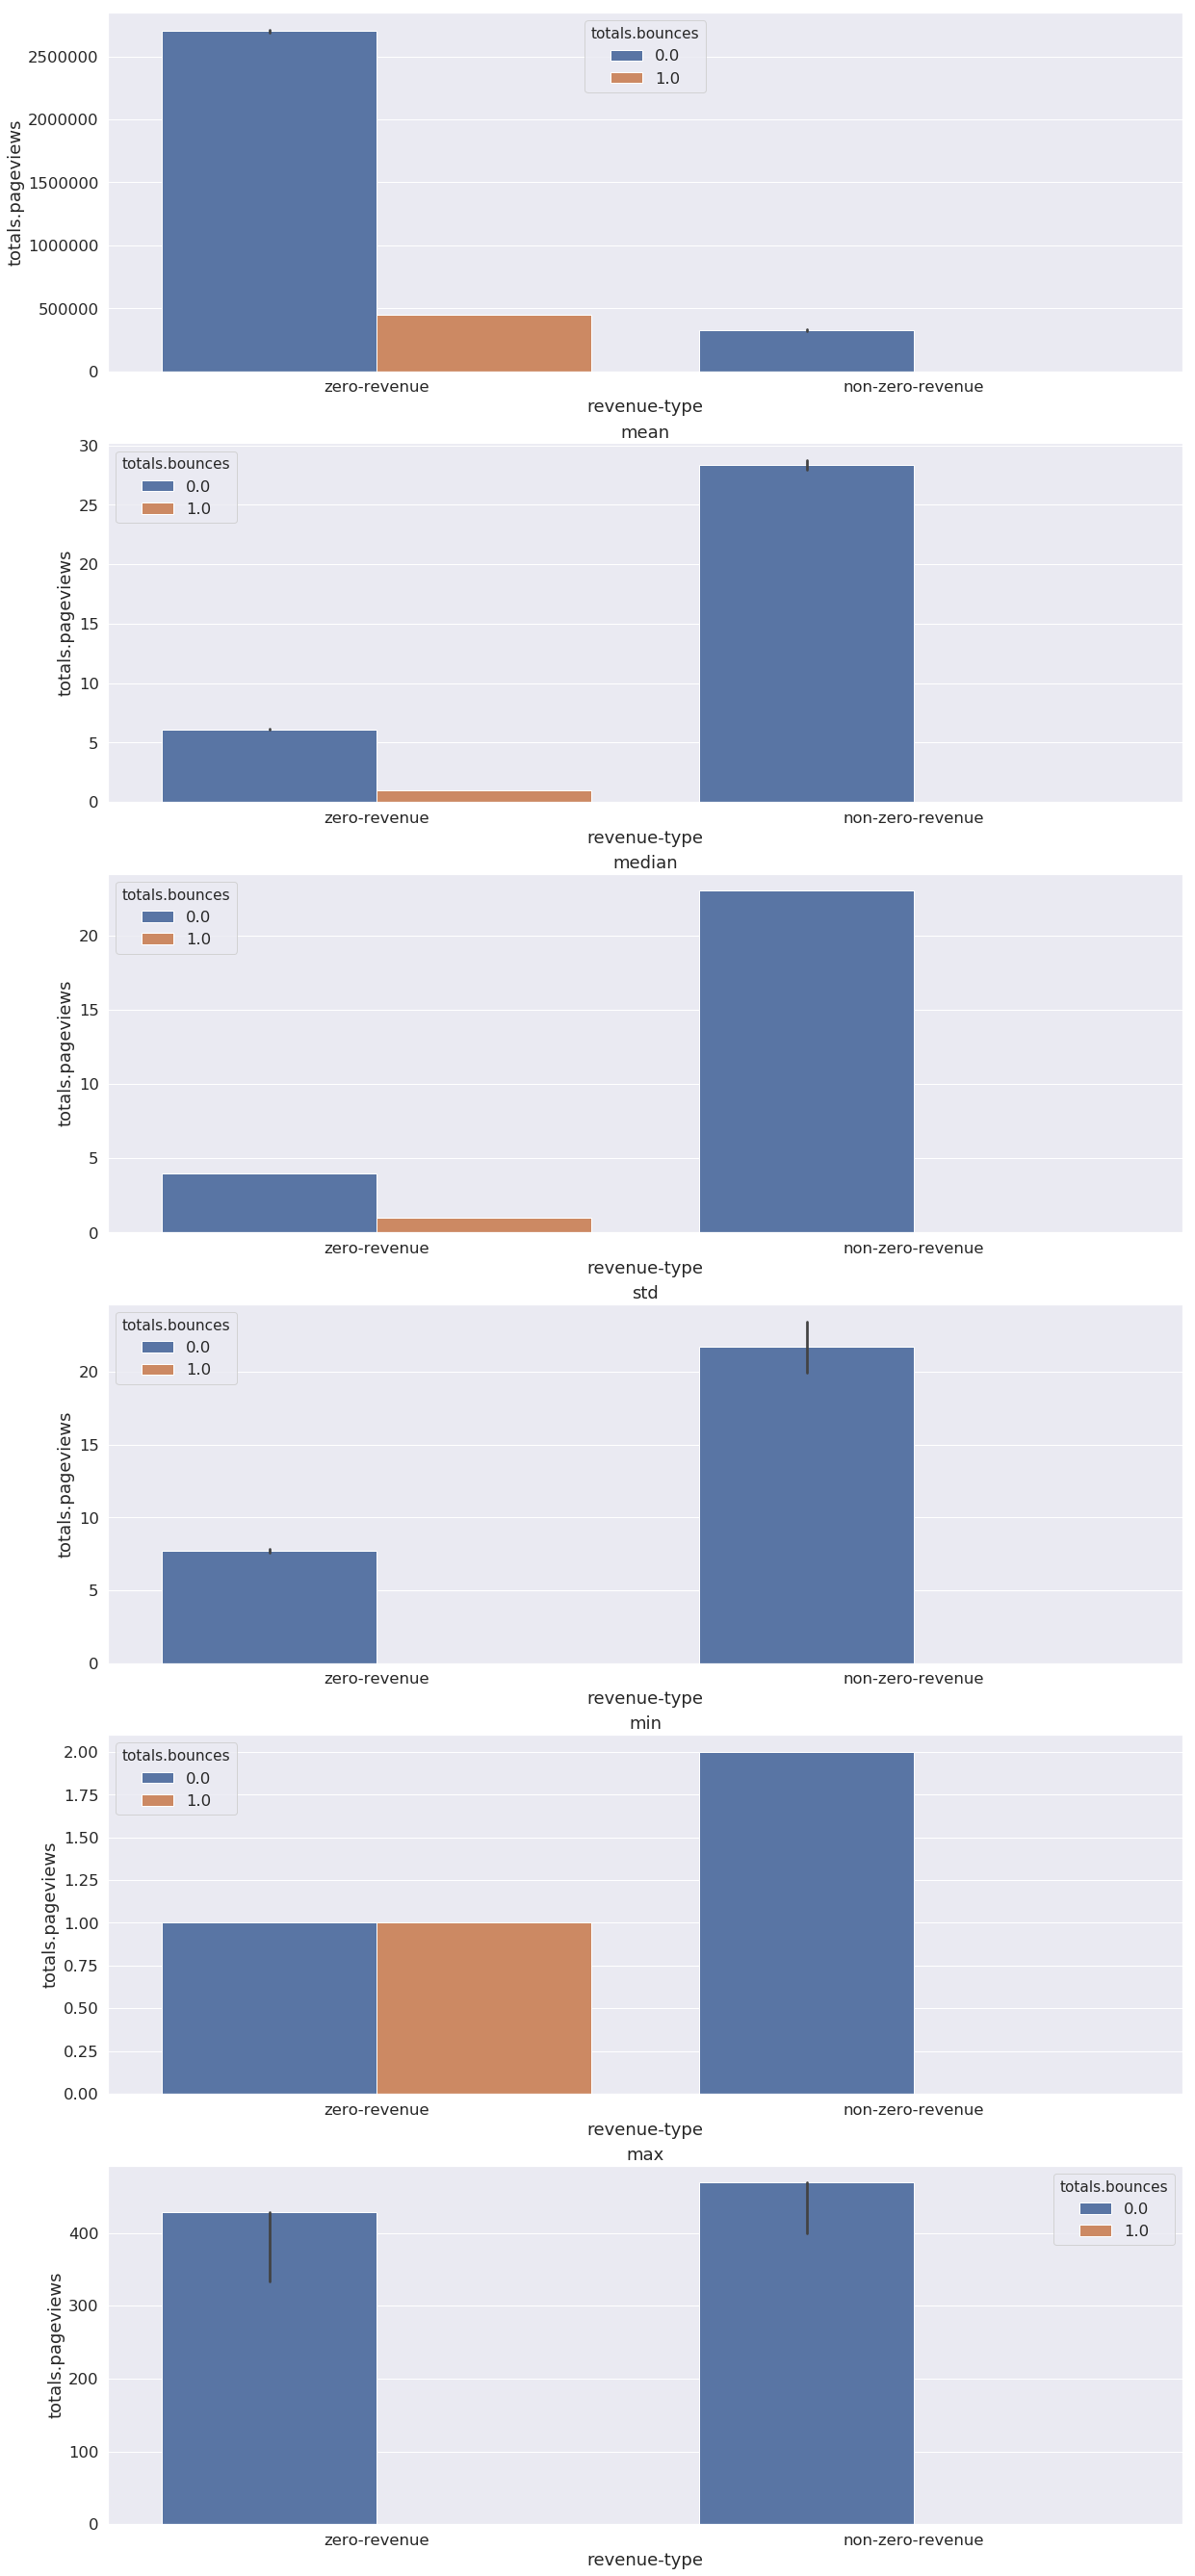

In [305]:
sns.set(font_scale=1.5)  # crazy big
fig, axs = plt.subplots(figsize=(20,48), nrows=6, ncols=1)

sns.barplot(x="revenue-type", y="totals.pageviews", hue="totals.bounces", estimator=sum, data=train, ax=axs[0])
sns.barplot(x="revenue-type", y="totals.pageviews", hue="totals.bounces", estimator=np.mean, data=train, ax=axs[1])
sns.barplot(x="revenue-type", y="totals.pageviews", hue="totals.bounces", estimator=np.median, data=train, ax=axs[2])
sns.barplot(x="revenue-type", y="totals.pageviews", hue="totals.bounces", estimator=np.std, data=train, ax=axs[3])
sns.barplot(x="revenue-type", y="totals.pageviews", hue="totals.bounces", estimator=np.min, data=train, ax=axs[4])
sns.barplot(x="revenue-type", y="totals.pageviews", hue="totals.bounces", estimator=np.max, data=train, ax=axs[5])

axs[1].set_title("mean")
axs[2].set_title("median")
axs[3].set_title("std")
axs[4].set_title("min")
axs[5].set_title("max")

# conclusion:
# non-bounce people who generate revenue have much more page views

# feature ==== exclude outliers first
# 1. non-bounce and views >= 2
# 2. non-bounce and views >= median (25)
# 3. pageviews == 1   ; 1 means no revenue for sure

Text(0.5, 1.0, 'max')

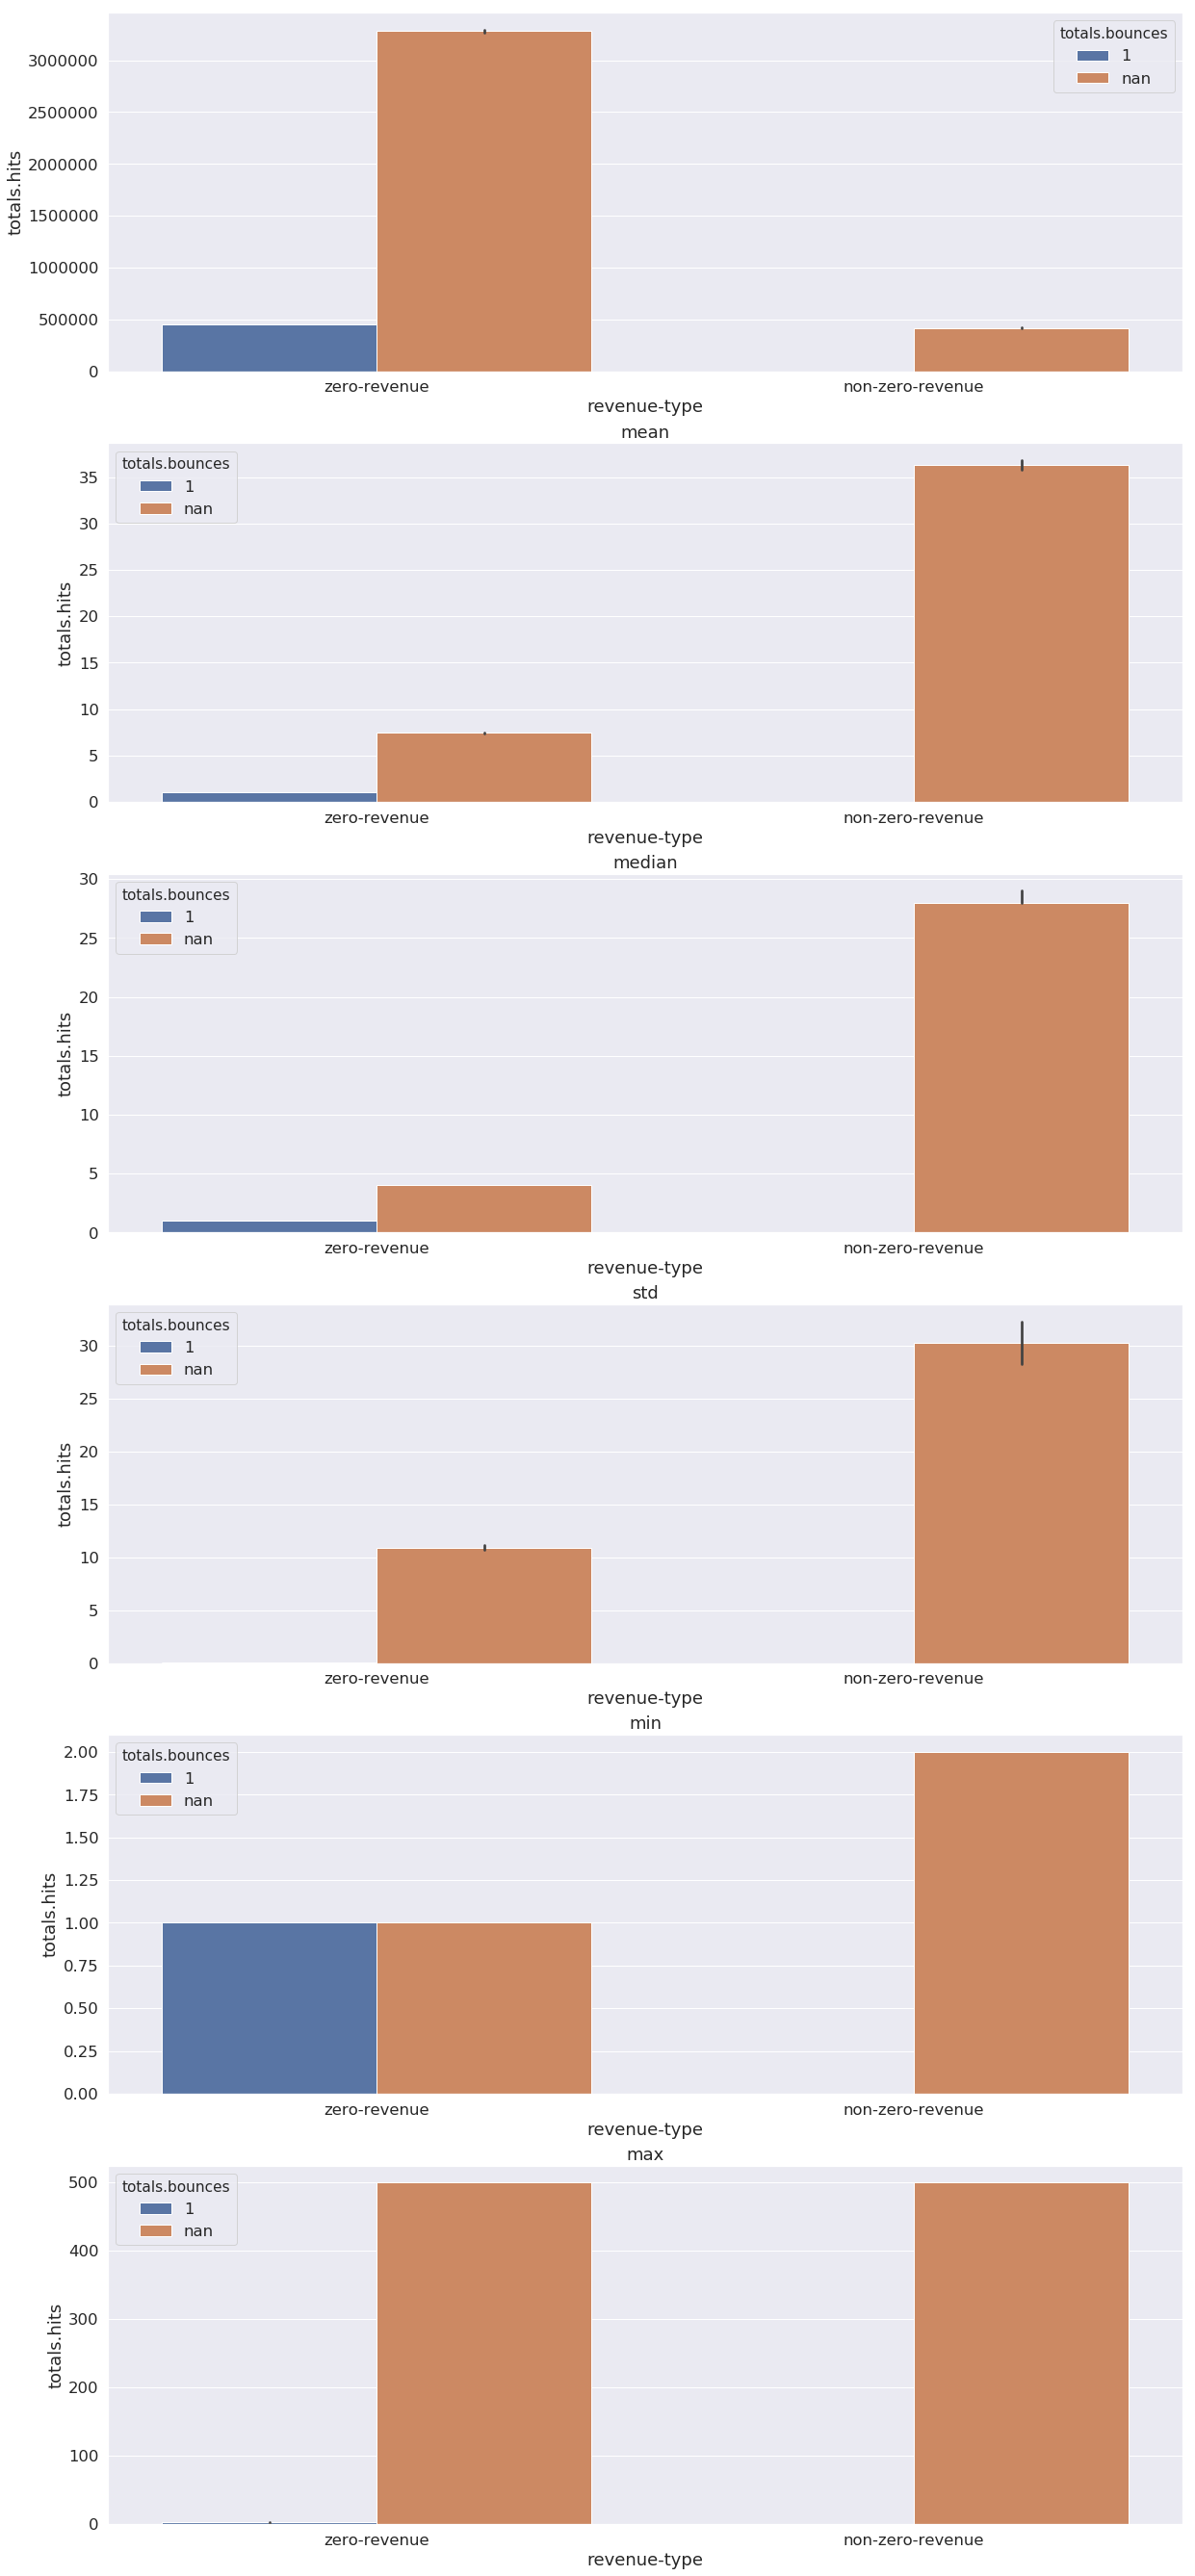

In [510]:
sns.set(font_scale=1.5)  # crazy big
fig, axs = plt.subplots(figsize=(20,48), nrows=6, ncols=1)

sns.barplot(x="revenue-type", y="totals.hits", hue="totals.bounces", estimator=sum, data=train, ax=axs[0])
sns.barplot(x="revenue-type", y="totals.hits", hue="totals.bounces", estimator=np.mean, data=train, ax=axs[1])
sns.barplot(x="revenue-type", y="totals.hits", hue="totals.bounces", estimator=np.median, data=train, ax=axs[2])
sns.barplot(x="revenue-type", y="totals.hits", hue="totals.bounces", estimator=np.std, data=train, ax=axs[3])
sns.barplot(x="revenue-type", y="totals.hits", hue="totals.bounces", estimator=np.min, data=train, ax=axs[4])
sns.barplot(x="revenue-type", y="totals.hits", hue="totals.bounces", estimator=np.max, data=train, ax=axs[5])

axs[1].set_title("mean")
axs[2].set_title("median")
axs[3].set_title("std")
axs[4].set_title("min")
axs[5].set_title("max")

# feature
# 1. on-bounce and hits >= median
# 2. on-bounce and hits >= mean

# Analyse time and location effect

In [541]:
location_cols = [c for c in train.columns if c.startswith("geoNetwork")]
print("Missing ratio")
for loc in location_cols:
    print(loc, "\t", train[loc].isnull().sum() / train.shape[0])

Missing ratio
geoNetwork.city 	 0.6003311005441248
geoNetwork.continent 	 0.0016245173755855401
geoNetwork.country 	 0.0016245173755855401
geoNetwork.metro 	 0.7856942875196563
geoNetwork.networkDomain 	 0.4325941484175895
geoNetwork.region 	 0.5932100042826174
geoNetwork.subContinent 	 0.0016245173755855401


In [556]:
train["geoNetwork.subContinent"].value_counts()

Northern America      390657
Southeast Asia         77800
Southern Asia          59321
Western Europe         59114
Northern Europe        58168
Eastern Asia           46919
Eastern Europe         45249
South America          41731
Western Asia           38443
Southern Europe        35780
Central America        15583
Australasia            14893
Northern Africa         7683
Western Africa          2573
Caribbean               2406
Southern Africa         2169
Eastern Africa          1927
Central Asia            1215
Middle Africa            393
Melanesia                 81
Micronesian Region        55
Polynesia                 25
Name: geoNetwork.subContinent, dtype: int64

In [546]:
train["geoNetwork.city"].value_counts().sort_index()

's Hertogenbosch                         7
Aalborg                                 41
Aalen                                    9
Aberdeen                                21
Abu Dhabi                               95
Adana                                  188
Adelaide                                18
Ahmedabad                              916
Akron                                   66
Alba                                     7
Alba Iulia                              21
Alexandria                              52
Alicante                                38
Allendale Charter Township               8
Almaty                                  33
Almeria                                 33
Altrincham                              14
Amberg                                  30
Amersfoort                               7
Amherst                                  6
Amsterdam                             1467
Amã                                     84
Anaheim                                  8
Ankara     

In [543]:
train["geoNetwork.networkDomain"].value_counts()

comcast.net                          28743
rr.com                               14827
verizon.net                          13637
ttnet.com.tr                         13228
comcastbusiness.net                   9985
hinet.net                             7919
virginm.net                           6414
3bb.co.th                             6046
prod-infinitum.com.mx                 5960
cox.net                               5812
sbcglobal.net                         5388
btcentralplus.com                     5304
att.net                               5230
google.com                            5035
optonline.net                         4972
totbb.net                             4895
vnpt.vn                               4508
asianet.co.th                         4374
pldt.net                              4008
rima-tde.net                          3963
amazonaws.com                         3769
t-ipconnect.de                        3656
telecomitalia.it                      3571
qwest.net  

In [531]:
train["geoNetwork.continent"].value_counts()

Americas    450377
Asia        223698
Europe      198311
Oceania      15054
Africa       14745
Name: geoNetwork.continent, dtype: int64

In [529]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.campaignCode', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source',
       'vi

In [528]:
date_cols = ["date", "fullVisitorId", "sessionId", "visitId", "visitNumber", "visitStartTime", "visitStartTimeDate"]
train[date_cols][train["sessionId"].duplicated(keep=False)].sort_values("sessionId").head(40)

,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,visitStartTimeDate
212026,2016-08-21,0011338928267756760,0011338928267756760_1471848731,1471848731,1,1471848731,2016-08-22 06:52:11
82177,2016-08-22,0011338928267756760,0011338928267756760_1471848731,1471848731,1,1471849330,2016-08-22 07:02:10
802549,2017-01-01,0014884852016449602,0014884852016449602_1483257533,1483257533,2,1483257729,2017-01-01 08:02:09
848579,2016-12-31,0014884852016449602,0014884852016449602_1483257533,1483257533,2,1483257533,2017-01-01 07:58:53
428607,2017-06-05,0019612470994343873,0019612470994343873_1496731675,1496731675,24,1496731675,2017-06-06 06:47:55
202287,2017-06-06,0019612470994343873,0019612470994343873_1496731675,1496731675,24,1496732439,2017-06-06 07:00:39
46654,2017-05-19,0031542961723593073,0031542961723593073_1495261490,1495261490,1,1495261490,2017-05-20 06:24:50
857846,2017-05-20,0031542961723593073,0031542961723593073_1495261490,1495261490,1,1495264358,2017-05-20 07:12:38
618667,2017-01-24,0039798900163330977,0039798900163330977_1485331011,1485331011,4,1485331011,2017-01-25 07:56:51
520542,2017-01-25,0039798900163330977,0039798900163330977_1485331011,1485331011,4,1485331307,2017-01-25 08:01:47


Text(0.5, 1.0, 'Non Zero Revenue Std')

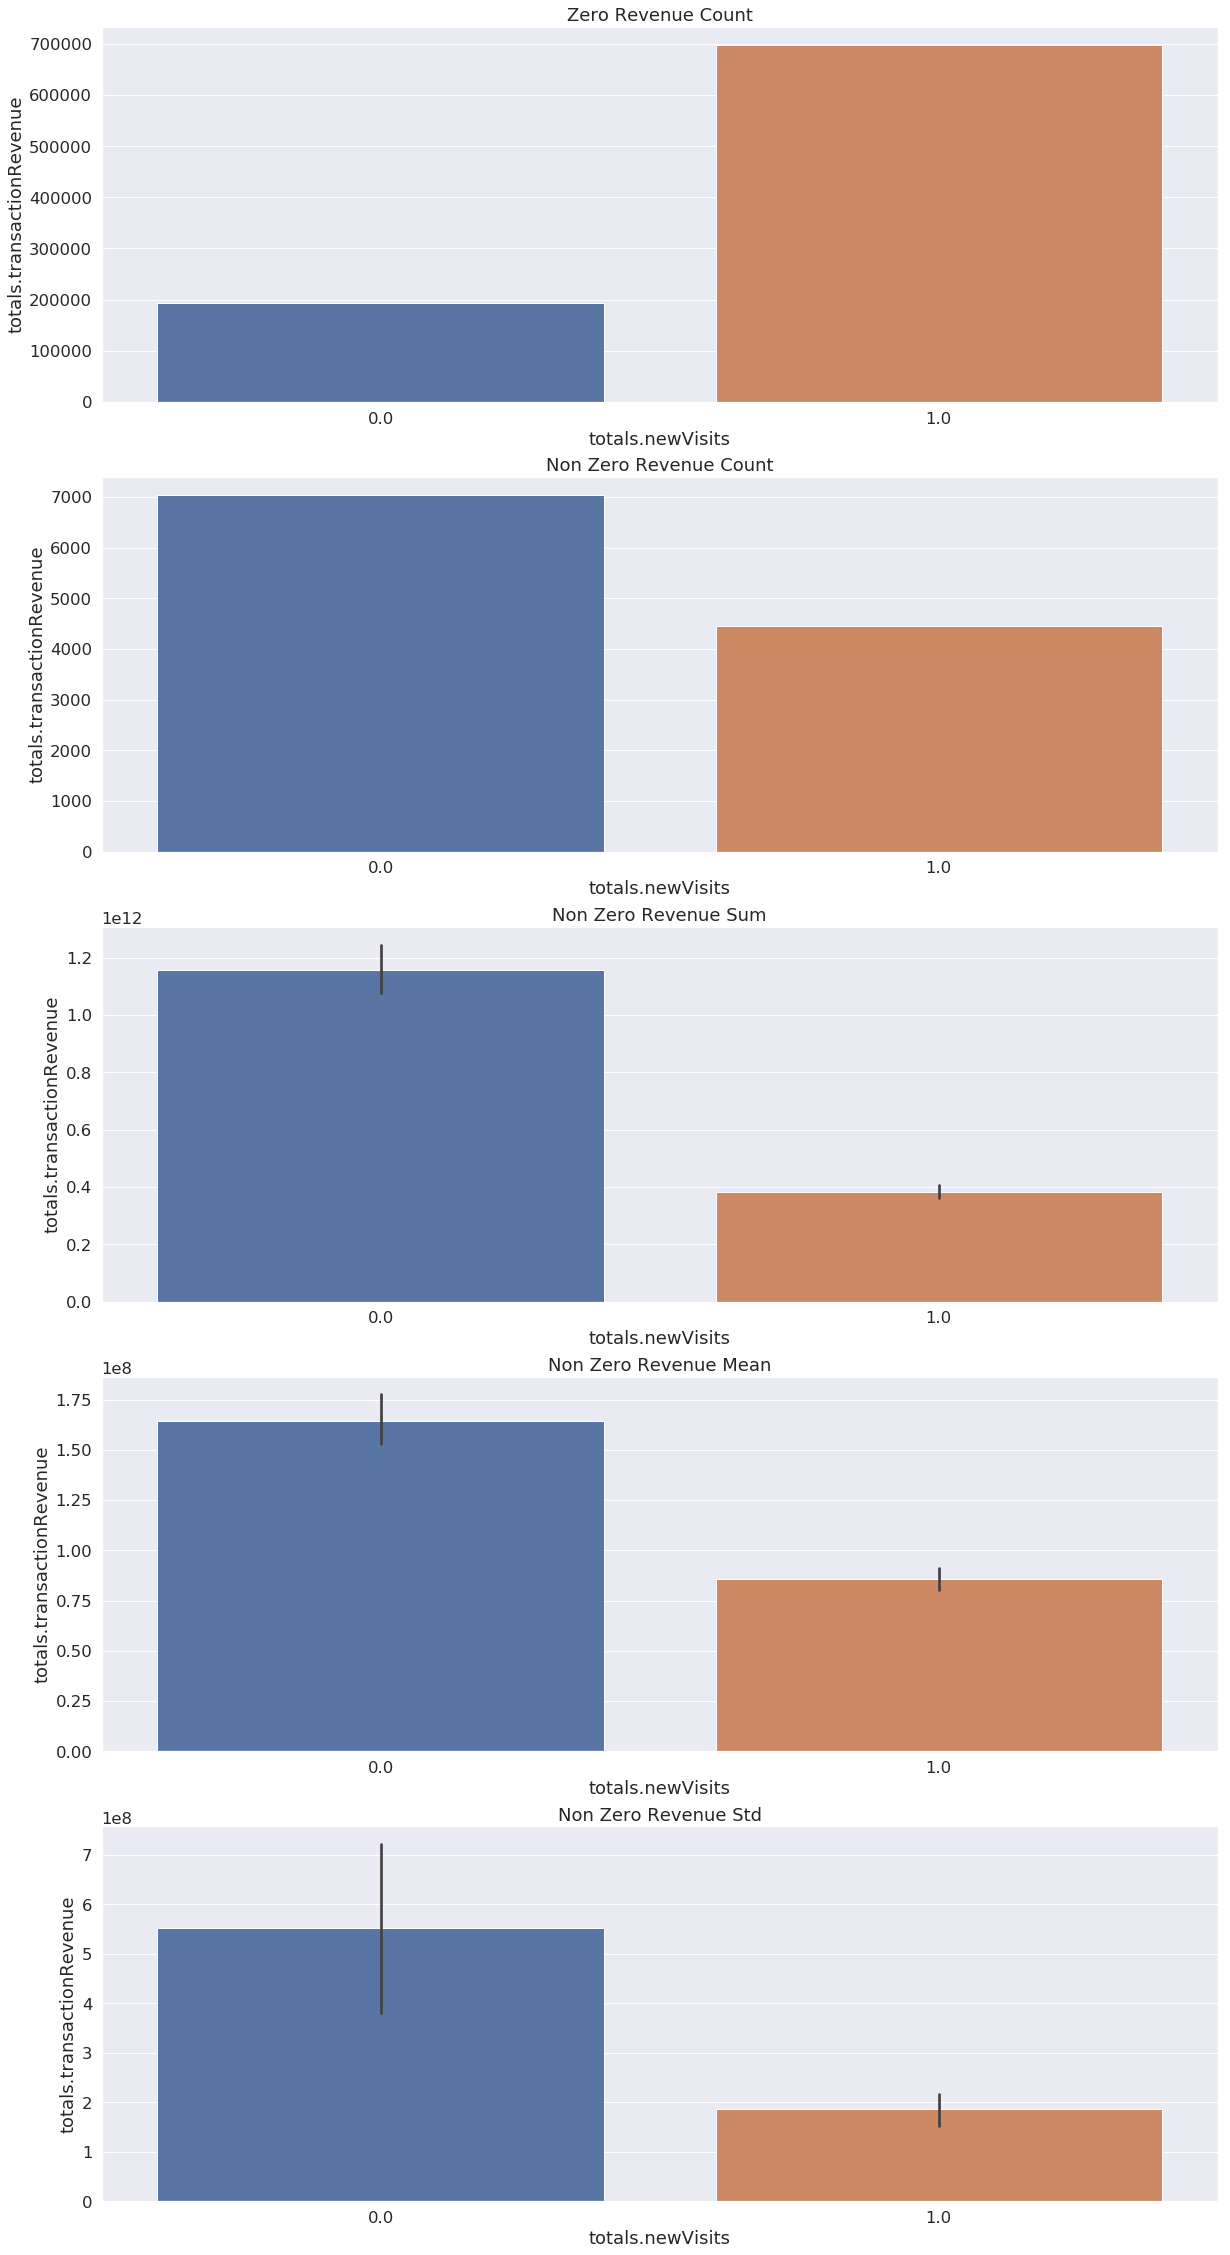

In [277]:
sns.set(font_scale=1.5)  # crazy big
fig, axs = plt.subplots(figsize=(20,40), nrows=5, ncols=1)


sns.barplot(x="totals.newVisits", y="totals.transactionRevenue", estimator=len, data=zero_train, ax=axs[0],)
sns.barplot(x="totals.newVisits", y="totals.transactionRevenue", estimator=len, data=non_zero_train, ax=axs[1])

sns.barplot(x="totals.newVisits", y="totals.transactionRevenue", estimator=sum, data=non_zero_train, ax=axs[2])
sns.barplot(x="totals.newVisits", y="totals.transactionRevenue", estimator=np.mean, data=non_zero_train, ax=axs[3])
sns.barplot(x="totals.newVisits", y="totals.transactionRevenue", estimator=np.std, data=non_zero_train, ax=axs[4])

axs[0].set_title("Zero Revenue Count")
axs[1].set_title("Non Zero Revenue Count")

axs[2].set_title("Non Zero Revenue Sum")
axs[3].set_title("Non Zero Revenue Mean")
axs[4].set_title("Non Zero Revenue Std")

In [ ]:
zero_train[zero_train[""]]

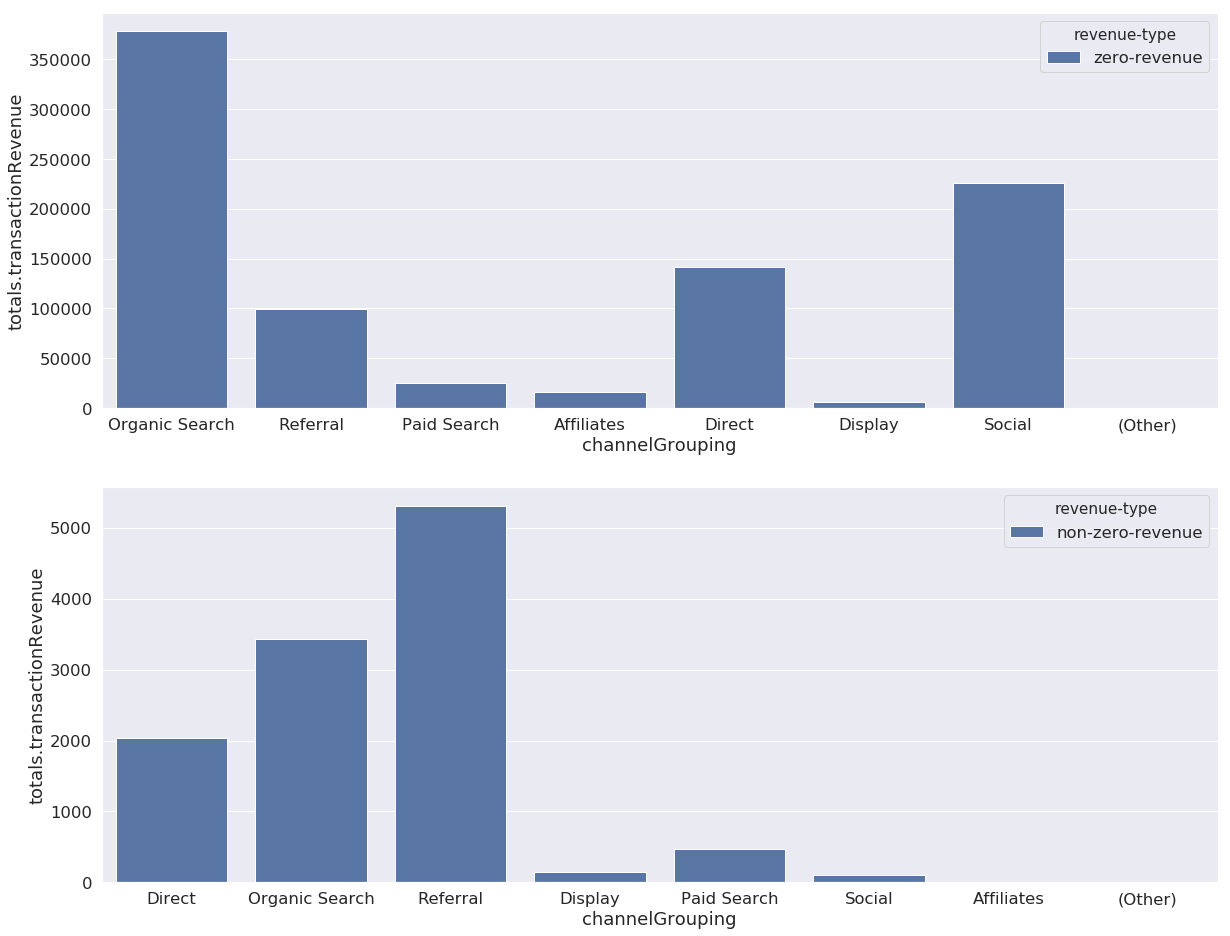

In [269]:
sns.set(font_scale=1.5)  # crazy big
fig, axs = plt.subplots(figsize=(20,16), nrows=2, ncols=1)
sns.barplot(x="channelGrouping", y="totals.transactionRevenue", hue="revenue-type", estimator=len, data=zero_train, ax=axs[0])
sns.barplot(x="channelGrouping", y="totals.transactionRevenue", hue="revenue-type", estimator=len, data=non_zero_train, ax=axs[1])

In [263]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.isVideoAd',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.campaignCode', 'trafficSource.isTrueDirect',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source',
       'vi

In [157]:
train["trafficSource.adwordsClickInfo.isVideoAd"].value_counts()

False    21460
Name: trafficSource.adwordsClickInfo.isVideoAd, dtype: int64

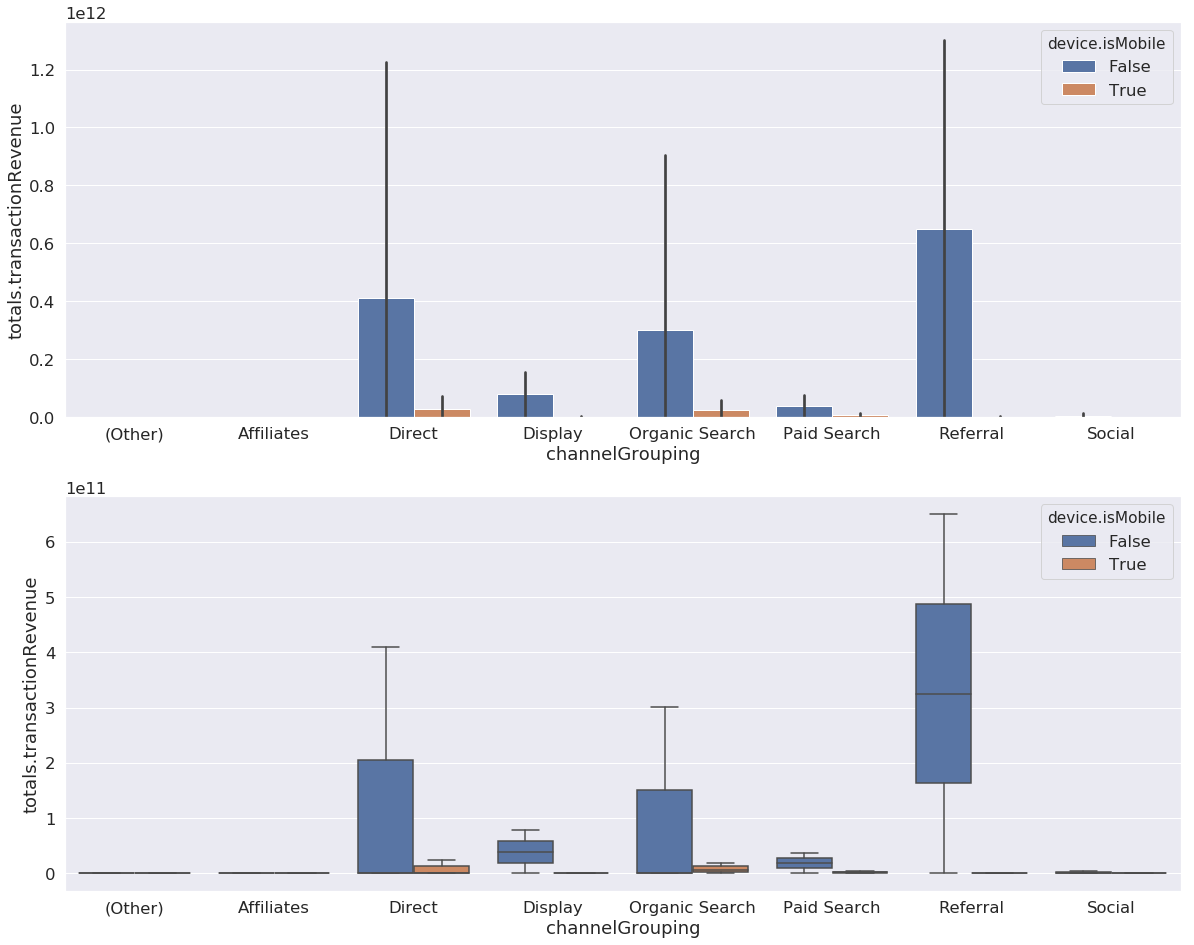

In [224]:
'''
estimator : callable that maps vector -> scalar, optional

Statistical function to estimate within each categorical bin.

or plt.show()
'''

sns.set(font_scale=1.5)  # crazy big
fig, axs = plt.subplots(figsize=(20,16), nrows=2, ncols=1)
cc = train.groupby(["channelGrouping", "device.isMobile", "device.deviceCategory"]).sum().reset_index()

sns.barplot(y="totals.transactionRevenue", x="channelGrouping", data=cc, orient="v", hue="device.isMobile", 
           estimator=sum, ax=axs[0])
sns.boxplot(y="totals.transactionRevenue", x="channelGrouping", data=cc,  hue="device.isMobile", ax=axs[1])

In [35]:
cc.reset_index()

,channelGrouping,device.isMobile,date,visitId,visitNumber,visitStartTime,totals.transactionRevenue
0,(Other),False,1653915668,122230244046,427,122230244500,0.000000e+00
1,(Other),True,766475808,56704191339,108,56704191339,9.990000e+06
2,Affiliates,False,299068918869,22031781538135,25211,22031781571018,5.834100e+08
3,Affiliates,True,31723961937,2342316424551,2007,2342316426403,1.397000e+07
4,Direct,False,1777148940783,130929814333022,309044,130929814536833,4.092737e+11
5,Direct,True,1107213884274,81654252494348,90565,81654252546729,2.556685e+10
6,Display,False,91995909585,6773547169654,47464,6773547174892,7.754181e+10
7,Display,True,34283519729,2527554872588,7604,2527554872757,7.956500e+08
8,Organic Search,False,4957164014950,365357343453765,605531,365357343719301,3.012590e+11
9,Organic Search,True,2737703303214,201921224843227,224645,201921224938721,2.512155e+10


In [ ]:
train["device.browser"].value_counts().reset_index

In [ ]:
vc = train["device.browser"].value_counts().reset_index

In [20]:
train["sessionId"].unique().shape, train.shape[0] - train["sessionId"].unique().shape[0]

((902755,), 898)

In [72]:
test["sessionId"].unique().shape, test.shape[0] - test["sessionId"].unique().shape[0]

((803863,), 821)

In [42]:
train[["sessionId", "fullVisitorId", "visitId", "visitNumber"]].head()

,sessionId,fullVisitorId,visitId,visitNumber
0,1131660440785968503_1472830385,1131660440785968503,1472830385,1
1,377306020877927890_1472880147,377306020877927890,1472880147,1
2,3895546263509774583_1472865386,3895546263509774583,1472865386,1
3,4763447161404445595_1472881213,4763447161404445595,1472881213,1
4,27294437909732085_1472822600,27294437909732085,1472822600,2


In [77]:
import datetime
print(datetime.datetime.utcfromtimestamp(1471848731).strftime('%Y-%m-%d %H:%M:%S'))
print(datetime.datetime.utcfromtimestamp(1471849330).strftime('%Y-%m-%d %H:%M:%S'))

2016-08-22 06:52:11
2016-08-22 07:02:10


In [79]:
train[train["sessionId"].duplicated(keep=False)].sort_values("sessionId")["visitStartTime"].apply(
lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')
).head(10)

212026    2016-08-22 06:52:11
82177     2016-08-22 07:02:10
802549    2017-01-01 08:02:09
848579    2017-01-01 07:58:53
428607    2017-06-06 06:47:55
202287    2017-06-06 07:00:39
46654     2017-05-20 06:24:50
857846    2017-05-20 07:12:38
618667    2017-01-25 07:56:51
520542    2017-01-25 08:01:47
Name: visitStartTime, dtype: object

In [96]:
train[train["sessionId"].duplicated(keep=False)].sort_values("sessionId").head(100)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
212026,Organic Search,20160821,0011338928267756760,0011338928267756760_1471848731,Not Socially Engaged,1471848731,1,1471848731,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,China,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,Eastern Asia,NaN,2,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
82177,Organic Search,20160822,0011338928267756760,0011338928267756760_1471848731,Not Socially Engaged,1471848731,1,1471849330,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Asia,China,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,Eastern Asia,NaN,2,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
802549,Referral,20170101,0014884852016449602,0014884852016449602_1483257533,Not Socially Engaged,1483257533,2,1483257729,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,Los Angeles,not available in demo dataset,Americas,United States,not available in demo dataset,not available in demo dataset,Los Angeles CA,(not set),not available in demo dataset,California,Northern America,NaN,10,NaN,6,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,True,NaN,referral,/,mall.googleplex.com
848579,Referral,20161231,0014884852016449602,0014884852016449602_1483257533,Not Socially Engaged,1483257533,2,1483257533,Chrome,not available in dem

In [112]:
basic_cols = ["fullVisitorId", "sessionId", "visitNumber", "visitStartTime"]
total_cols = [c for c in train.columns if c.startswith("totals")]
train[basic_cols + total_cols].head(50)

,fullVisitorId,sessionId,visitNumber,visitStartTime,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits
0,1131660440785968503,1131660440785968503_1472830385,1,1472830385,1,1,1,1,NaN,1
1,377306020877927890,377306020877927890_1472880147,1,1472880147,1,1,1,1,NaN,1
2,3895546263509774583,3895546263509774583_1472865386,1,1472865386,1,1,1,1,NaN,1
3,4763447161404445595,4763447161404445595_1472881213,1,1472881213,1,1,1,1,NaN,1
4,27294437909732085,27294437909732085_1472822600,2,1472822600,1,1,NaN,1,NaN,1
5,2938943183656635653,2938943183656635653_1472807194,1,1472807194,1,1,1,1,NaN,1
6,1905672039242460897,1905672039242460897_1472817241,1,1472817241,1,1,1,1,NaN,1
7,537222803633850821,537222803633850821_1472812602,1,1472812602,1,1,1,1,NaN,1
8,4445454811831400414,4445454811831400414_1472805784,1,1472805784,1,1,1,1,NaN,1
9,9499785259412240342,9499785259412240342_1472812272,1,1472812272,1,1,1,1,NaN,1


In [21]:
se_visit_count = train[["fullVisitorId", "sessionId", "visitNumber"]].groupby("fullVisitorId").count()

# Conclusion: # visitNumber == # session for a certain user
sum(se_visit_count["sessionId"] == se_visit_count["visitNumber"]), se_visit_count.shape

# number of session == number of visits

(714167, (714167, 2))

In [15]:
train["totals.visits"].astype("int").sum() / train.shape[0]

1.0

In [11]:
train["totals.bounces"].value_counts(), train["totals.bounces"].isnull().sum()/ train.shape[0]

(1    450630
 Name: totals.bounces, dtype: int64, 0.5013240701906595)

In [23]:
train["channelGrouping"].value_counts()

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64

In [ ]:
train["totals.hits"].value_counts()

In [119]:
train["totals.newVisits"].isnull().sum() / train.shape[0], train["totals.visits"].isnull().sum()

(0.22198011847468, 0)

In [ ]:
trian.groupby(["fullVisitorId", "session"])

In [95]:
train[train["sessionId"].duplicated(keep=False)]["totals.transactionRevenue"].shape

(1796,)

In [41]:
se_counts = train["sessionId"].value_counts()
se_counts[se_counts != 1].shape, se_counts[se_counts != 1].value_counts(), se_counts[se_counts > 2]

((898,), 2    898
 Name: sessionId, dtype: int64, Series([], Name: sessionId, dtype: int64))

In [90]:
train["fullVisitorId"].unique().shape, test["fullVisitorId"].unique().shape, len(set(train["fullVisitorId"]) & set(test["fullVisitorId"]))

((714167,), (617242,), 7679)

In [83]:
gdf = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

In [89]:
nzi = pd.notnull(train["totals.transactionRevenue"]).sum()
nzr = (gdf["totals.transactionRevenue"]>0).sum()
print("Number of instances in train set with non-zero revenue : ", nzi, " and ratio is : ", nzi / train.shape[0])
print("Number of unique customers with non-zero revenue : ", nzr, "and the ratio is : ", nzr / gdf.shape[0])

Number of instances in train set with non-zero revenue :  11515  and ratio is :  0.0127427231470487
Number of unique customers with non-zero revenue :  9996 and the ratio is :  0.013996726255903731


In [40]:
se_counts[se_counts != 1].value_counts()

2    898
Name: sessionId, dtype: int64

In [19]:
train[["sessionId", "fullVisitorId", "visitId", "visitNumber"]].head()

,sessionId,fullVisitorId,visitId,visitNumber
0,1131660440785968503_1472830385,1131660440785968503,1472830385,1
1,377306020877927890_1472880147,377306020877927890,1472880147,1
2,3895546263509774583_1472865386,3895546263509774583,1472865386,1
3,4763447161404445595_1472881213,4763447161404445595,1472881213,1
4,27294437909732085_1472822600,27294437909732085,1472822600,2


In [11]:
train["totals.transactionRevenue"].isnull().count(), train["totals.transactionRevenue"].isnull().sum() / train.shape[0]

(903653, 0.9872572768529513)

# Taken from discussion and kernels

In [98]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

train_df = train
# Device Browser
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



Inferences:

Device browser distribution looks similar on both the count and count of non-zero revenue plots

On the device category front, desktop seem to have higher percentage of non-zero revenue counts compared to mobile devices.

In device operating system, though the number of counts is more from windows, the number of counts where revenue is not zero is more for Macintosh.
Chrome OS also has higher percentage of non-zero revenue counts

On the mobile OS side, iOS has more percentage of non-zero revenue counts compared to Android

In [99]:
import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]



Inferences:

1. We have data from 1 Aug, 2016 to 31 July, 2017 in our training dataset
2. In Nov 2016, though there is an increase in the count of visitors, there is no increase in non-zero revenue counts during that time period (relative to the mean).

In [100]:
test_df = test
test_df['date'] = test_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = test_df.groupby('date')['fullVisitorId'].size()


trace = scatter_plot(cnt_srs, 'red')

layout = go.Layout(
    height=400,
    width=800,
    paper_bgcolor='rgb(233,233,233)',
    title='Dates in Test set'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

In the test set, we have dates from 2 Aug, 2017 to 30 Apr, 2018. So there are no common dates between train and test set. So it might be a good idea to do time based validation for this dataset.

In [101]:
# Continent
cnt_srs = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

# Network domain
cnt_srs = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]
[ (3,1) x7,y7 ]  [ (3,2) x8,y8 ]  [ (3,3) x9,y9 ]



In [102]:
# Continent
cnt_srs = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



In [24]:
train["channelGrouping"].value_counts()

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64

In [34]:
# social + referral == referral
# none == direct
# paid search == cpc (cost per click)
# cpm = display
train["trafficSource.medium"].value_counts(), train["trafficSource.medium"].isnull().sum() / train.shape[0]

(organic      381561
 referral     330955
 (none)       143026
 cpc           25326
 affiliate     16403
 cpm            6262
 (not set)       120
 Name: trafficSource.medium, dtype: int64, 0.0)

In [32]:
226117 + 104838

330955

In [33]:
train["trafficSource.source"].isnull().sum() / train.shape[0]

0.0

In [31]:
train["trafficSource.source"].value_counts()

google                                                          400788
youtube.com                                                     212602
(direct)                                                        143028
mall.googleplex.com                                              66416
Partners                                                         16411
analytics.google.com                                             16172
dfa                                                               5686
google.com                                                        4669
m.facebook.com                                                    3365
baidu                                                             3356
sites.google.com                                                  2983
facebook.com                                                      2296
siliconvalley.about.com                                           2097
reddit.com                                                        2022
qiita.

In [30]:
train["tr"]

(organic      381561
 referral     330955
 (none)       143026
 cpc           25326
 affiliate     16403
 cpm            6262
 (not set)       120
 Name: trafficSource.medium, dtype: int64, 0.0)

In [103]:
# Page views
cnt_srs = train_df.groupby('totals.pageviews')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(60), 'cyan')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'cyan')
trace5 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'cyan')

# Hits
cnt_srs = train_df.groupby('totals.hits')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", 'mean']
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace3 = horizontal_bar_chart(cnt_srs["count"].head(60), 'black')
trace4 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(60), 'black')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(60), 'black')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Total Pageviews - Count", "Total Pageviews - Non-zero Revenue Count", "Total Pageviews - Mean Revenue",
                                          "Total Hits - Count",  "Total Hits - Non-zero Revenue Count", "Total Hits - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace5, 1, 3)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Visitor Profile Plots")
py.iplot(fig, filename='visitor-profile-plots')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



Inferences:

Both these variables look very predictive
1. Count plot shows decreasing nature i.e. we have a very high total count for less number of hits and page views per visitor transaction and the overall count decreases when the number of hits per visitor transaction increases.
2. On the other hand, we can clearly see that when the number of hits / pageviews per visitor transaction increases, we see that there is a high number of non-zero revenue counts.

In [ ]:
https://www.kaggleusercontent.com/kf/5984854/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..xdzW50xURLqTyNN84r_UYw.sxy3s9RA7n8pORmUpXINoMCIAFESiygl77D4zpAaEjI3ASAGkUBFLhXm8Wm-yn_aI3tpBB7vwf3pqdH8RdIKF5BKXLUJsX-3tXk6vyFY3IPZdxnbPgqOKpHjx1Ekhdgyp7jBF_ai5jh5uKd_L1N0QDLI3AGQtdhVUjzYT5gx0IH2_3TLAtZrO82EStEihaF2.g0p9A--RdnLVcP6IGRMMEw/__results___files/__results___39_0.png

In [ ]:
cols_to_drop = const_cols + ['sessionId']

train_df = train_df.drop(cols_to_drop + ["trafficSource.campaignCode"], axis=1)
test_df = test_df.drop(cols_to_drop, axis=1)


# Impute 0 for missing target values
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values


# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser", 
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent", "trafficSource.adContent", 
            "trafficSource.adwordsClickInfo.adNetworkType", 
            "trafficSource.adwordsClickInfo.gclId", 
            "trafficSource.adwordsClickInfo.page", 
            "trafficSource.adwordsClickInfo.slot", "trafficSource.campaign",
            "trafficSource.keyword", "trafficSource.medium", 
            "trafficSource.referralPath", "trafficSource.source",
            'trafficSource.adwordsClickInfo.isVideoAd', 'trafficSource.isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))


num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime", 'totals.bounces',  'totals.newVisits']    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date']<=datetime.date(2017,5,31)]
val_df = train_df[train_df['date']>datetime.date(2017,5,31)]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 